In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import imageio
import random
import time
from itertools import permutations
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from sklearn.cluster import AgglomerativeClustering
from IPython.display import clear_output
import seaborn as sns; sns.set()
from scipy.stats import entropy
#from sklearn import metrics
#from sklearn.datasets.samples_generator import make_blobs
#from sklearn.preprocessing import StandardScaler
#from skimage import img_as_ubyte
from faker import Faker

In [2]:
def sig_func(x,y):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        y: The second parameter.

    Returns:
        The return value.
        
    """
    
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def mutate(x,rate):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        rate: The second parameter.

    Returns:
        The return value.
        
    """
    
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = 2*np.random.random(1)-1
    return(x)

In [4]:
def intersection(lst1, lst2):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    return list(set(lst1) & set(lst2))

In [5]:
def extract_tribe(cells, cell_weights, fake_names, n, labels, node_n = 225):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    db = AgglomerativeClustering(n).fit(cell_weights)
    print(db.labels_)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    flags = flags[1:]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    next_fake_names = [fake_names[x] for x in flags]
    print(next_fake_names)
    return(next_cells[0], next_weights[0], next_fake_names[0], db)

In [6]:
def fuzzy_logic(a):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    less_norm = np.linalg.norm([i for i in a if i <= np.median(a)])
    cutoff = np.min(a)/less_norm + np.random.rand()*((np.median(a)-np.min(a))/less_norm)
    choice = a.index(np.random.choice([i for i in a if i <= cutoff*less_norm]))
    
    return(choice)

In [7]:
def slime(x = [],
          y = [],
          z = [],
          start_pop = 200,
          max_age = 100,
          fig_size = [5,5],
          board_size = 128,
          fertile = 6,
          start_hp = 3,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 1,
          willing_wait = 5,
          experimental = False,
          mode='once'):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.

    """
    
    global sight
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global baby_name
    global killed
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    global max_hp
    global frame_count
    global fake
    global fake_names
    
    fake = Faker()    
    total_start_time = time.time()
    frame_count = 1
    max_hp = fertile
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    baby_name = 1
    fake_names = fake.name()
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Build the initial cell list.  Skip this if one from a previous run is submitted.
    # The NN is built around sight/input of 9*9, movement/output of 3*3.
    if(len(x) < 1):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        
        for cell in range(0,start_pop):
            cells[cell,:] = [baby_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          start_hp,
                          1]
            cell_weights[cell,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(cell)
            baby_name += 1
            fake_names = np.append(fake_names,fake.name())
            
    else:
        cells = x
        cell_weights = y
        fake_names = z
        baby_name = len(z) + 1

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(10*X)
        return(im,)
    
    # Get the relative coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    keep = [0,0]
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='magma', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global baby_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        global max_hp
        global frame_count
        global fake
        global fake_names
        
        """Example function with PEP 484 type annotations.

        Args:
            lst1: The first parameter.
            lst2: The second parameter.

        Returns:
            The return value.

        """
        
        # Warning for long frame generation wait time.
        if(last_time > willing_wait):
            print("Taking too long...  Frame {} took {} seconds.".format((frame_count-1),round(last_time,1)))
        
        # Initial values.
        start_time = time.time()
        grow_count = 0
        birth_count = 0
        bump_count = 0
        killed_this_round = np.array([], dtype = int)
        
        # Take turns through the cell list for each frame.
        time_tick += 1
        im.set_data(10*animate.X)
        
        try:
            p = (np.transpose(PCA(n_components=3).fit(np.transpose(cell_weights)).components_)+1)/2
            rgb = np.round(255*(p-np.min(p))/(np.max(p)-np.min(p)))/((256^2)*256 + 256*256 + 256)
            cell_color = (256^2)*rgb[:,0] + 256*rgb[:,1] + rgb[:,2]
            
        except:
            print("Extinction event occured!  Had to return.")
            return(im,)
        
        cell_count = len(cells)
        
        for cell in range(0, cell_count):
            if(int(cells[cell,0] in killed_this_round) == 0):
                # Input.
                test_in = []
                for perm in np.mod(cells[cell,1:3] + np.unique(keep,axis=0), board_size):
                    test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])

                # Output.
                test_out = sig_func(test_in,cell_weights[cell,:].reshape((sight*sight, 3*3)))
                d = fuzzy_logic(test_out.tolist())

                # Rest and recover up to half fertile health.
                if(d==4):
                    if(cells[cell,3] < max_hp/2):
                        cells[cell,3] += 1
                        grow_count += 1
                        if(log == True):
                            print("{} raised hp to {}.".format(fake_names[cell], cells[cell,3]))

                    # Handle birth/splitting, don't clear.
                    if(cells[cell,3] >= max_hp):

                        # Get the relative coodinates for possible baby locations.
                        L = [0, 0, 1, 1, -1, -1]
                        keep2 = [0,0]
                        for comb in permutations(L, r=2):
                            keep2 = np.vstack((keep2, comb))
                        potential = []
                        for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                            potential = np.append(potential, X[int(perm[0]), int(perm[1])])

                        # Check if location for baby is clear
                        clear = []
                        for i in potential:
                            if(i == 0):
                                clear = np.append(clear,i)

                        # Cell division process, only divide if there is a vacant destination to choose from.
                        if(len(clear) > 0):
                            d = np.random.choice(range(0,len(clear)))
                            # Give new coordinate and fill it in.
                            destination = np.mod(np.add(cells[int(cell),1:3], new_coord[d]), board_size)

                            # Half parent hp.
                            divided_hp = np.floor(cells[cell,3]/2)
                            cells[cell,3] = divided_hp

                            # Give the baby attributes.
                            G.add_node(baby_name)
                            G.add_edge(cells[cell,0], baby_name)
                            fake_baby_name = fake.name()
                            fake_names = np.append(fake_names,fake_baby_name)

                            a = [baby_name,
                                 int(destination[0]),
                                 int(destination[1]),
                                 divided_hp,
                                 1]

                            # Mutate the baby's NN
                            b = mutate(cell_weights[cell,:], mutation_rate)
                            cells = np.vstack((cells, a)) 
                            cell_weights = np.vstack((cell_weights, b))
                            p = (np.transpose(PCA(n_components=3).fit(np.transpose(cell_weights)).components_)+1)/2
                            rgb = np.round(255*(p-np.min(p))/(np.max(p)-np.min(p)))/((256^2)*256 + 256*256 + 256)
                            X[int(destination[0]), int(destination[1])] = (256^2)*rgb[cell,0] + 256*rgb[cell,1] + rgb[cell,2]
                            
                            baby_name += 1
                            birth_count += 1
                            if(log == True):
                                print("{} underwent mitosis.  Gave birth to {}.".format(fake_names[cell], fake_baby_name))

                # Movement logic.
                else:
                    # If it is clear to move.
                    destination = np.mod(np.add(cells[cell,1:3], new_coord[d]), board_size)

                    if(X[int(destination[0]), int(destination[1])] == 0):
                        # Clear where it was since it is not splitting.
                        last_spot = cells[cell,1:3]
                        X[int(last_spot[0]),int(last_spot[1])] = 0         
                        # Give new coordinate and fill it in.
                        cells[cell,1:3] = destination
                        X[int(destination[0]), int(destination[1])] = cell_color[cell]

                    else:
                        # It has an altercation    
                        x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                        y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                        z = intersection(x,y)

                        # Make sure there is no ambiguity
                        if(len(z) == 1):
                            z = z[0]
                            # The outcome is determined by hit points, age and who is initiating.
                            # The following ratio incorperates ages of predator and prey
                            rat = np.log(cells[z,4]/cells[cell,4])/np.e

                            # Experimental ################################################
                            if(experimental == True):
                                # Get the relative coodinates
                                L = [0, 0, 1, 1, -1, -1]
                                keep2 = [0,0]
                                for comb in permutations(L, r=2):
                                    keep2 = np.vstack((keep2, comb))
                                potential = []
                                for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                                    potential = np.append(potential, X[int(perm[0]), int(perm[1])])
                            ###############################################################

                            if(cells[cell,3] > cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] += np.round(3+rat)
                                cells[z,3] -= np.round(3+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))


                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))     
                                ###############################################################

                            if(cells[cell,3] == cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] += np.round(1+rat)
                                cells[z,3] -= np.round(1+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))
                                ###############################################################

                            if(cells[cell,3] < cells[z,3]):
                                attacker_hp_before = cells[cell,3]
                                defender_hp_before = cells[z,3]
                                cells[cell,3] -= np.round(2-rat)
                                cells[z,3] += np.round(2-rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[cell], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[cell], attacker_hp_before, cells[cell,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(0,9)))
                                    reward[d] = 1
                                    cell_weights[cell,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward)) 
                                ###############################################################

                            # Experimental ################################################
                            if(log == True):
                                print("Experimental nurture reenforcement modified {}'s neural network.".format(fake_names[cell]))  
                            ###############################################################

                            bump_count += 1
                            
                            # Handle cell death.
                            if(cells[cell,3] < 1):
                                # Clear where the attacker was and add to the death list.
                                last_spot = cells[cell,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                                if(log == True):
                                    print("{} collapsed from injury!.".format(fake_names[cell]))

                            if(cells[z,3] < 1):
                                # Clear where the victim was and add to the death list.
                                last_spot = cells[z,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[z,0]))
                                if(log == True):
                                    print("{} collapsed from injury!.".format(fake_names[z]))
                                    
        # Kill the elderly        
        for cell in range(0, cell_count):
            if(cells[cell,4] > max_age):
                # Blur max age a bit.
                if(np.random.random() < (cells[cell,4]-max_age)/max_age):      
                    # Add to the death list.
                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                    if(log == True):
                        print("{} collapsed from old age!.".format(fake_names[cell]))

        # Finally handle the death list and delete cells
        for i in np.unique(killed_this_round):
            j = list(cells[:,0]).index((i))
            last_spot = cells[j,1:3]
            X[int(last_spot[0]),int(last_spot[1])] = 0
            if(log == True):
                print("{} died at age {}.".format(fake_names[j],cells[j,4]))
            cells = np.delete(cells, (j), axis=0)
            cell_weights = np.delete(cell_weights, (j), axis=0)
            fake_names = np.delete(fake_names, (j))

        # Dynamic population control
        if(np.random.random() < -np.log(cell_count/(start_pop)/np.e)):
            if(max_hp > 3):
                    max_hp -= 1
                    print("We're going extinct, make babies!  Breeding requirements decreased to {}.".format(max_hp))

        if(np.random.random() < np.log(cell_count/(start_pop)/np.e)):
                max_hp += 1
                print("Too crowded, stop having kids!  Breeding requirements increased to {}.".format(max_hp))

        mean_var = np.mean(np.var(cell_weights,axis = 0))
        cell_count = len(cells)

        # Tick everyone's age
        cells[:,4] = np.add(cells[:,4],1)
        # Capture array for gif
        for_gif = np.concatenate((for_gif, X))
        # Capture death statistics
        death_count = len(np.unique(killed_this_round))
        # Current frame summary
        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count, cell_count, mean_var])
        # Append to run summary
        trends = np.vstack((trends, current))
        # Get the current frame run time to check next frame
        last_time = time.time() - start_time
        # Log every 10 frames to monitor full run time and check frame generation time.
        if(np.mod(frame_count,10) == 0):
            #clear_output(wait=True)
            print("Frame {} took {} seconds.".format(frame_count,round(last_time,1)))
        frame_count += 1
    
        return(im,)
    
    # Handles the browser animation viewer.
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make a little animated gif
    images = []
    for i in range(0,(frames+1)):
        converted = np.reshape(for_gif,(len(trends),board_size,board_size))[int(i),:,:]
        imageio.imwrite('slime.gif', converted)
        #clear_output(wait=True)
        images.append(imageio.imread('slime.gif'))
    imageio.mimsave('slime.gif', images)
    
    # Total run time
    total_last_time = time.time() - total_start_time
    #clear_output(wait=True)
    print("Total Run Time:  {} seconds.".format(round(total_last_time,1)))
    
    return(html_result, cells, cell_weights, fake_names, G, trends[1:,:], for_gif)

In [8]:
gr, c, cw, fn, g, t, a = slime(frames=500, experimental = True, log = True)

Elizabeth Proctor attacked Marcus Fletcher!
Elizabeth Proctor hp: 4.0 --> 5.0
Marcus Fletcher hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Elizabeth Proctor's neural network.
Danielle Nelson attacked Kimberly Wilson MD!
Danielle Nelson hp: 4.0 --> 5.0
Kimberly Wilson MD hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Danielle Nelson's neural network.
Ashley Costa attacked Paul Mcdonald!
Ashley Costa hp: 4.0 --> 5.0
Paul Mcdonald hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Ashley Costa's neural network.
Chad Reynolds attacked Timothy Bond!
Chad Reynolds hp: 4.0 --> 5.0
Timothy Bond hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Chad Reynolds's neural network.
Mary White attacked David Yang!
Mary White hp: 4.0 --> 5.0
David Yang hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Mary White's neural network.
John Greene attacked Vincent Mejia!
John Greene hp: 4.0 --> 5.0
Vincent Mejia hp: 4.0 --> 3.0
Experimental nurture ree

Sarah Shaw underwent mitosis.  Gave birth to Robert Hughes.
Sara Walker attacked Natalie Wilson!
Sara Walker hp: 4.0 --> 5.0
Natalie Wilson hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Sara Walker's neural network.
Corey Robinson underwent mitosis.  Gave birth to Brian Nunez.
Megan Waller underwent mitosis.  Gave birth to Jessica Estrada.
Denise Bridges underwent mitosis.  Gave birth to Paula Williams.
Elizabeth Cross underwent mitosis.  Gave birth to Lori Holland.
Katherine Miller underwent mitosis.  Gave birth to Pamela Perry.
Julie Rodriguez attacked Shane Mcbride!
Julie Rodriguez hp: 4.0 --> 5.0
Shane Mcbride hp: 4.0 --> 3.0
Experimental nurture reenforcement modified Julie Rodriguez's neural network.
Ashley Brown attacked Joshua Martinez!
Ashley Brown hp: 4.0 --> 2.0
Joshua Martinez hp: 8.0 --> 10.0
Experimental nurture reenforcement modified Ashley Brown's neural network.
Brandon Tapia attacked Bill Valentine!
Brandon Tapia hp: 2.0 --> 3.0
Bill Valentine hp: 2.0 --

John Greene underwent mitosis.  Gave birth to Jamie Ross.
Christina Bishop attacked Pam Acevedo!
Christina Bishop hp: 3.0 --> 1.0
Pam Acevedo hp: 4.0 --> 6.0
Experimental nurture reenforcement modified Christina Bishop's neural network.
Nicole Patterson raised hp to 2.0.
Paula Williams attacked Evan Schmidt MD!
Paula Williams hp: 2.0 --> 3.0
Evan Schmidt MD hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Paula Williams's neural network.
Lori Holland underwent mitosis.  Gave birth to Nicolas Acosta.
Jason Burke died at age 6.0.
Chad Reynolds died at age 6.0.
Amanda Ortega died at age 4.0.
Joseph Dougherty died at age 2.0.
Austin Obrien attacked Lynn Small!
Austin Obrien hp: 1.0 --> -1.0
Lynn Small hp: 8.0 --> 10.0
Experimental nurture reenforcement modified Austin Obrien's neural network.
Austin Obrien collapsed from injury!.
Karl Anderson attacked Sergio Keller!
Karl Anderson hp: 3.0 --> 6.0
Sergio Keller hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Karl And

Sarah Shaw underwent mitosis.  Gave birth to Courtney Thompson.
Sara Walker attacked Natalie Wilson!
Sara Walker hp: 9.0 --> 12.0
Natalie Wilson hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Sara Walker's neural network.
Natalie Wilson collapsed from injury!.
Robert Petersen underwent mitosis.  Gave birth to Christine Mcguire.
Vincent Mejia attacked Daniel Burton!
Vincent Mejia hp: 3.0 --> 5.0
Daniel Burton hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Vincent Mejia's neural network.
Daniel Burton collapsed from injury!.
Sherry Morse raised hp to 2.0.
Julie Rodriguez underwent mitosis.  Gave birth to Nicole Gallegos.
Lori Mckee underwent mitosis.  Gave birth to Mark Lopez.
Rebecca Woods underwent mitosis.  Gave birth to Claire Baxter.
Ronald Wells attacked Brian Aguilar!
Ronald Wells hp: 13.0 --> 16.0
Brian Aguilar hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Ronald Wells's neural network.
Brian Aguilar collapsed from injury!.
Jill Burke un

Anthony Mcintyre attacked Aaron Nunez!
Anthony Mcintyre hp: 2.0 --> 3.0
Aaron Nunez hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Anthony Mcintyre's neural network.
Seth Brown underwent mitosis.  Gave birth to Garrett Watson.
Charles Davis underwent mitosis.  Gave birth to Mark Atkinson.
Crystal Wallace underwent mitosis.  Gave birth to Joshua Walsh.
Justin Spears attacked Michelle Clarke!
Justin Spears hp: 7.0 --> 10.0
Michelle Clarke hp: 3.0 --> 0.0
Experimental nurture reenforcement modified Justin Spears's neural network.
Michelle Clarke collapsed from injury!.
William Boyd attacked Ricky Diaz!
William Boyd hp: 2.0 --> 3.0
Ricky Diaz hp: 2.0 --> 1.0
Experimental nurture reenforcement modified William Boyd's neural network.
Joseph Swanson attacked Roy Mosley!
Joseph Swanson hp: 2.0 --> 3.0
Roy Mosley hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Joseph Swanson's neural network.
Ronald Wells underwent mitosis.  Gave birth to Keith Caldwell.
Jason Lopez att

Jessica Sanchez attacked Leonard Dunn!
Jessica Sanchez hp: 2.0 --> 3.0
Leonard Dunn hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Jessica Sanchez's neural network.
Kelly Mccarty attacked Joseph King!
Kelly Mccarty hp: 2.0 --> 3.0
Joseph King hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Kelly Mccarty's neural network.
Kimberly Wilson MD attacked Christina Schmidt!
Kimberly Wilson MD hp: 3.0 --> 6.0
Christina Schmidt hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Kimberly Wilson MD's neural network.
Christina Schmidt collapsed from injury!.
Joseph Morton underwent mitosis.  Gave birth to Olivia Pena DVM.
Jason Knight underwent mitosis.  Gave birth to Bradley Orr.
Roy Mosley raised hp to 2.0.
Sherry Morse raised hp to 2.0.
Lori Mckee underwent mitosis.  Gave birth to William Marsh.
Aaron Murphy underwent mitosis.  Gave birth to Tina Garcia.
Nicholas Huang attacked Roy Waters!
Nicholas Huang hp: 2.0 --> -1.0
Roy Waters hp: 3.0 --> 6.0
Experimental

Daniel Castillo attacked Joseph Swanson!
Daniel Castillo hp: 4.0 --> 7.0
Joseph Swanson hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Daniel Castillo's neural network.
Joseph Swanson collapsed from injury!.
Tracy Johnson attacked Justin Spears!
Tracy Johnson hp: 3.0 --> 1.0
Justin Spears hp: 10.0 --> 12.0
Experimental nurture reenforcement modified Tracy Johnson's neural network.
Patricia Salazar underwent mitosis.  Gave birth to Kevin Sanchez.
Michael Meyer attacked Tina Arias!
Michael Meyer hp: 1.0 --> -2.0
Tina Arias hp: 4.0 --> 7.0
Experimental nurture reenforcement modified Michael Meyer's neural network.
Michael Meyer collapsed from injury!.
Garrett Watson attacked Christopher Costa!
Garrett Watson hp: 2.0 --> 3.0
Christopher Costa hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Garrett Watson's neural network.
Mark Atkinson underwent mitosis.  Gave birth to Nicole Wagner.
Mrs. Elizabeth Jackson underwent mitosis.  Gave birth to Jennifer Davila.
Stacey 

Garrett Watson underwent mitosis.  Gave birth to Jennifer Lee.
Keith Caldwell attacked Brittney Barnes!
Keith Caldwell hp: 2.0 --> 0.0
Brittney Barnes hp: 8.0 --> 10.0
Experimental nurture reenforcement modified Keith Caldwell's neural network.
Keith Caldwell collapsed from injury!.
Sergio Thomas underwent mitosis.  Gave birth to Ann Robertson.
Olivia Pena DVM raised hp to 2.0.
Colleen Curry raised hp to 2.0.
Eric Heath attacked Bradley Orr!
Eric Heath hp: 1.0 --> -1.0
Bradley Orr hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Eric Heath's neural network.
Eric Heath collapsed from injury!.
John Campbell attacked Jorge Wilson!
John Campbell hp: 6.0 --> 9.0
Jorge Wilson hp: 4.0 --> 1.0
Experimental nurture reenforcement modified John Campbell's neural network.
Daniel Dean raised hp to 2.0.
Catherine Medina attacked Jose Chang!
Catherine Medina hp: 1.0 --> 3.0
Jose Chang hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Catherine Medina's neural network.
Jose Chang

Jennifer Lee underwent mitosis.  Gave birth to George Stark.
Catherine Mcdowell underwent mitosis.  Gave birth to Sean Greer.
Jennifer Hardin attacked Christopher Miller!
Jennifer Hardin hp: 2.0 --> 5.0
Christopher Miller hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Jennifer Hardin's neural network.
Christopher Miller collapsed from injury!.
Paul Mcdonald died at age 21.0.
Ruth Barajas died at age 21.0.
Lori Mckee died at age 21.0.
Christina Bishop died at age 19.0.
Meredith Mata died at age 16.0.
Mark Collins died at age 15.0.
Alyssa Goodwin died at age 5.0.
Amy Mitchell died at age 3.0.
Debra Henry died at age 3.0.
Mr. Robert Rangel DVM died at age 2.0.
Christopher Miller died at age 2.0.
Jessica Sanchez underwent mitosis.  Gave birth to Stephen Lopez.
Leslie Willis attacked Mr. Geoffrey Clark!
Leslie Willis hp: 2.0 --> -1.0
Mr. Geoffrey Clark hp: 6.0 --> 9.0
Experimental nurture reenforcement modified Leslie Willis's neural network.
Leslie Willis collapsed from injur

Timothy Bond attacked Brittney Barnes!
Timothy Bond hp: 7.0 --> 5.0
Brittney Barnes hp: 10.0 --> 12.0
Experimental nurture reenforcement modified Timothy Bond's neural network.
Jill Burke raised hp to 2.0.
Jessica Houston raised hp to 2.0.
Candace Odom raised hp to 2.0.
Peter Whitehead raised hp to 2.0.
Megan Davis raised hp to 2.0.
Michelle Frederick underwent mitosis.  Gave birth to Travis Jensen DDS.
Tina Garcia attacked Francisco Joyce!
Tina Garcia hp: 2.0 --> 0.0
Francisco Joyce hp: 7.0 --> 9.0
Experimental nurture reenforcement modified Tina Garcia's neural network.
Tina Garcia collapsed from injury!.
Joyce Freeman underwent mitosis.  Gave birth to Mallory Herman.
Daniel Dean attacked Cheryl Sanchez!
Daniel Dean hp: 2.0 --> 5.0
Cheryl Sanchez hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Daniel Dean's neural network.
Cheryl Sanchez collapsed from injury!.
Marvin Walton attacked Elizabeth Proctor!
Marvin Walton hp: 6.0 --> 9.0
Elizabeth Proctor hp: 3.0 --> 0.0
Exper

Francisco Joyce attacked Jason Turner!
Francisco Joyce hp: 9.0 --> 13.0
Jason Turner hp: 2.0 --> -2.0
Experimental nurture reenforcement modified Francisco Joyce's neural network.
Jason Turner collapsed from injury!.
Heather Jones attacked Aaron Murphy!
Heather Jones hp: 8.0 --> 10.0
Aaron Murphy hp: 8.0 --> 6.0
Experimental nurture reenforcement modified Heather Jones's neural network.
Nicole Hurst attacked Jill Kim!
Nicole Hurst hp: 3.0 --> 6.0
Jill Kim hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Nicole Hurst's neural network.
Jill Kim collapsed from injury!.
Jack Copeland attacked Samantha Chung!
Jack Copeland hp: 1.0 --> 2.0
Samantha Chung hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Jack Copeland's neural network.
Samantha Chung collapsed from injury!.
Scott Hines raised hp to 2.0.
Kristen Brown attacked Matthew Keller!
Kristen Brown hp: 1.0 --> 2.0
Matthew Keller hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Kristen Brown's neural net

Julie Rodriguez underwent mitosis.  Gave birth to Melissa Hernandez.
Courtney Thompson attacked Michael Robinson!
Courtney Thompson hp: 1.0 --> -2.0
Michael Robinson hp: 4.0 --> 7.0
Experimental nurture reenforcement modified Courtney Thompson's neural network.
Courtney Thompson collapsed from injury!.
Christine Mcguire attacked Megan Carson!
Christine Mcguire hp: 6.0 --> 9.0
Megan Carson hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Christine Mcguire's neural network.
Megan Carson collapsed from injury!.
Joshua Walsh attacked Caleb Johnson!
Joshua Walsh hp: 8.0 --> 6.0
Caleb Johnson hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Joshua Walsh's neural network.
Raymond Fritz attacked Anita Allen!
Raymond Fritz hp: 2.0 --> 3.0
Anita Allen hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Raymond Fritz's neural network.
Dawn Santana raised hp to 2.0.
Sean Mckee DDS attacked Michael Robinson!
Sean Mckee DDS hp: 4.0 --> 1.0
Michael Robinson hp: 7.0 -->

John Dixon attacked Jeff Thomas!
John Dixon hp: 2.0 --> 2.0
Jeff Thomas hp: 2.0 --> 2.0
Experimental nurture reenforcement modified John Dixon's neural network.
Jason Knight attacked Scott Hines!
Jason Knight hp: 2.0 --> 3.0
Scott Hines hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Jason Knight's neural network.
Andrea Holden attacked Justin Weber!
Andrea Holden hp: 2.0 --> 3.0
Justin Weber hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Andrea Holden's neural network.
Jenna Reed underwent mitosis.  Gave birth to David Newman.
Danielle Nelson attacked Jeffrey Johnston!
Danielle Nelson hp: 2.0 --> 2.0
Jeffrey Johnston hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Danielle Nelson's neural network.
Shane Franco attacked Leslie Villarreal!
Shane Franco hp: 2.0 --> 2.0
Leslie Villarreal hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Shane Franco's neural network.
Mark Lopez attacked Christine Mcguire!
Mark Lopez hp: 2.0 --> 0.0
Christine 

Dylan Moore underwent mitosis.  Gave birth to Jennifer Hoffman.
Andrea Holden attacked Stephen Lopez!
Andrea Holden hp: 3.0 --> 1.0
Stephen Lopez hp: 4.0 --> 6.0
Experimental nurture reenforcement modified Andrea Holden's neural network.
Elizabeth Ballard raised hp to 2.0.
Joseph Patterson attacked Ricky Davis!
Joseph Patterson hp: 3.0 --> 3.0
Ricky Davis hp: 3.0 --> 3.0
Experimental nurture reenforcement modified Joseph Patterson's neural network.
Jason Fox attacked Susan Smith!
Jason Fox hp: 2.0 --> 2.0
Susan Smith hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Jason Fox's neural network.
Nathan Hammond attacked David Bradshaw!
Nathan Hammond hp: 2.0 --> -1.0
David Bradshaw hp: 11.0 --> 14.0
Experimental nurture reenforcement modified Nathan Hammond's neural network.
Nathan Hammond collapsed from injury!.
Casey Myers MD attacked Elizabeth Ballard!
Casey Myers MD hp: 3.0 --> 6.0
Elizabeth Ballard hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Casey Myers MD'

Katherine Perez attacked Roy Waters!
Katherine Perez hp: 7.0 --> 8.0
Roy Waters hp: 7.0 --> 6.0
Experimental nurture reenforcement modified Katherine Perez's neural network.
Dylan Moore attacked David Mcdonald!
Dylan Moore hp: 2.0 --> -1.0
David Mcdonald hp: 4.0 --> 7.0
Experimental nurture reenforcement modified Dylan Moore's neural network.
Dylan Moore collapsed from injury!.
Jennifer Flores attacked Justin Spears!
Jennifer Flores hp: 2.0 --> 0.0
Justin Spears hp: 12.0 --> 14.0
Experimental nurture reenforcement modified Jennifer Flores's neural network.
Jennifer Flores collapsed from injury!.
Joseph King attacked Tiffany Jackson!
Joseph King hp: 2.0 --> 0.0
Tiffany Jackson hp: 17.0 --> 19.0
Experimental nurture reenforcement modified Joseph King's neural network.
Joseph King collapsed from injury!.
Roy Waters attacked Katherine Perez!
Roy Waters hp: 6.0 --> 4.0
Katherine Perez hp: 8.0 --> 10.0
Experimental nurture reenforcement modified Roy Waters's neural network.
John Campbell und

Brittney Barnes underwent mitosis.  Gave birth to Andrew Stark.
Shane Franco attacked Ashley Richard!
Shane Franco hp: 1.0 --> -2.0
Ashley Richard hp: 4.0 --> 7.0
Experimental nurture reenforcement modified Shane Franco's neural network.
Shane Franco collapsed from injury!.
Christine Mcguire attacked Jeanne Morales!
Christine Mcguire hp: 14.0 --> 17.0
Jeanne Morales hp: 7.0 --> 4.0
Experimental nurture reenforcement modified Christine Mcguire's neural network.
Ashley Jacobs attacked Dawn Santana!
Ashley Jacobs hp: 2.0 --> 3.0
Dawn Santana hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Ashley Jacobs's neural network.
John Campbell underwent mitosis.  Gave birth to Natalie Gray.
Tina Arias underwent mitosis.  Gave birth to Kyle Vargas.
Toni Curry raised hp to 2.0.
Dawn Santana raised hp to 2.0.
Heather Jones attacked Seth Fernandez!
Heather Jones hp: 2.0 --> 5.0
Seth Fernandez hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Heather Jones's neural network.
Seth F

Janice Martinez underwent mitosis.  Gave birth to Kirk Alexander.
Seth Brown died at age 47.0.
Brandon Tapia died at age 47.0.
Jennifer Baker died at age 14.0.
Jo Johnson died at age 1.0.
Katherine Perez attacked Kelly Sanders!
Katherine Perez hp: 10.0 --> 12.0
Kelly Sanders hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Katherine Perez's neural network.
Kelly Sanders collapsed from injury!.
Christie Solomon raised hp to 2.0.
Shelby Erickson attacked Dawn Santana!
Shelby Erickson hp: 2.0 --> 3.0
Dawn Santana hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Shelby Erickson's neural network.
Brenda Johnson raised hp to 2.0.
Colleen Curry underwent mitosis.  Gave birth to Frank Chavez DDS.
Debra Haas underwent mitosis.  Gave birth to Kenneth Lawson.
Ann Robertson underwent mitosis.  Gave birth to Brittney Velez.
Scott Booth underwent mitosis.  Gave birth to Jade Duran.
Amanda Harris underwent mitosis.  Gave birth to Jennifer York.
Renee Harrell attacked Brooke Brow

Michael Robinson underwent mitosis.  Gave birth to Mr. Anthony Ortiz DDS.
Meghan Ortega raised hp to 2.0.
Jessica Smith attacked Jonathon Fisher!
Jessica Smith hp: 3.0 --> 1.0
Jonathon Fisher hp: 11.0 --> 13.0
Experimental nurture reenforcement modified Jessica Smith's neural network.
Martha Sims raised hp to 2.0.
Ashley Richard underwent mitosis.  Gave birth to Charles Hanson.
Natalie Gray raised hp to 2.0.
Anne Matthews attacked Christopher Mason!
Anne Matthews hp: 1.0 --> -1.0
Christopher Mason hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Anne Matthews's neural network.
Anne Matthews collapsed from injury!.
Kirk Alexander attacked Colleen Curry!
Kirk Alexander hp: 2.0 --> 4.0
Colleen Curry hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Kirk Alexander's neural network.
Colleen Curry collapsed from injury!.
Jennifer York underwent mitosis.  Gave birth to Gregory White.
Danielle Villegas attacked Natalie Gray!
Danielle Villegas hp: 3.0 --> 6.0
Natalie Gray h

Heather Robertson underwent mitosis.  Gave birth to John Allen.
Kaitlyn Price attacked Laura Morris!
Kaitlyn Price hp: 2.0 --> 3.0
Laura Morris hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Kaitlyn Price's neural network.
Michael Bray raised hp to 2.0.
Thomas Kelley attacked Jacob Williams!
Thomas Kelley hp: 1.0 --> 0.0
Jacob Williams hp: 2.0 --> 3.0
Experimental nurture reenforcement modified Thomas Kelley's neural network.
Thomas Kelley collapsed from injury!.
Nicole Baldwin underwent mitosis.  Gave birth to Patricia Flowers.
Mr. Anthony Ortiz DDS underwent mitosis.  Gave birth to Michele Jacobson.
Samuel Wilson underwent mitosis.  Gave birth to Makayla Barber.
Robert Petersen died at age 53.0.
Sergio Thomas died at age 41.0.
Catherine Mcdowell died at age 34.0.
Thomas Kelley died at age 3.0.
Scott Zimmerman died at age 2.0.
Michelle Rojas died at age 2.0.
Ashley Costa attacked Janice Brown!
Ashley Costa hp: 3.0 --> 3.0
Janice Brown hp: 3.0 --> 3.0
Experimental nurture 

Gary Dorsey underwent mitosis.  Gave birth to Thomas Huang.
Kenneth Lawson raised hp to 2.0.
Matthew Vasquez attacked Steven Snow!
Matthew Vasquez hp: 3.0 --> 3.0
Steven Snow hp: 3.0 --> 3.0
Experimental nurture reenforcement modified Matthew Vasquez's neural network.
Paige Cox attacked Scott Kane!
Paige Cox hp: 7.0 --> 7.0
Scott Kane hp: 7.0 --> 7.0
Experimental nurture reenforcement modified Paige Cox's neural network.
Tamara Black raised hp to 2.0.
Matthew Harris attacked Elizabeth Payne!
Matthew Harris hp: 1.0 --> 2.0
Elizabeth Payne hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Matthew Harris's neural network.
Elizabeth Payne collapsed from injury!.
Paula Castro attacked Derek Stevens!
Paula Castro hp: 1.0 --> -1.0
Derek Stevens hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Paula Castro's neural network.
Paula Castro collapsed from injury!.
Denise Cooper attacked Gregory White!
Denise Cooper hp: 10.0 --> 13.0
Gregory White hp: 6.0 --> 3.0
Experimental n

Ian Jones attacked Mary Nelson!
Ian Jones hp: 25.0 --> 27.0
Mary Nelson hp: 7.0 --> 5.0
Experimental nurture reenforcement modified Ian Jones's neural network.
Margaret Black attacked Michelle Frederick!
Margaret Black hp: 2.0 --> 0.0
Michelle Frederick hp: 12.0 --> 14.0
Experimental nurture reenforcement modified Margaret Black's neural network.
Margaret Black collapsed from injury!.
Timothy Bond underwent mitosis.  Gave birth to Patrick Mclaughlin.
Stephen Lopez underwent mitosis.  Gave birth to Amanda Pace.
Denise Carter attacked Caleb Goodman!
Denise Carter hp: 7.0 --> 4.0
Caleb Goodman hp: 8.0 --> 11.0
Experimental nurture reenforcement modified Denise Carter's neural network.
Andrew Hodge attacked Corey Robinson!
Andrew Hodge hp: 2.0 --> 3.0
Corey Robinson hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Andrew Hodge's neural network.
Ashley Bailey underwent mitosis.  Gave birth to Michael Carney.
Erin Gonzales attacked Lawrence Simon!
Erin Gonzales hp: 2.0 --> 3.0
Law

Stephanie Peters underwent mitosis.  Gave birth to Mary Hendricks.
Brian Malone attacked Denise Carter!
Brian Malone hp: 3.0 --> 7.0
Denise Carter hp: 2.0 --> -2.0
Experimental nurture reenforcement modified Brian Malone's neural network.
Denise Carter collapsed from injury!.
Caleb Goodman attacked Edwin Odonnell!
Caleb Goodman hp: 16.0 --> 19.0
Edwin Odonnell hp: 4.0 --> 1.0
Experimental nurture reenforcement modified Caleb Goodman's neural network.
John Collins attacked Daniel Smith!
John Collins hp: 2.0 --> 0.0
Daniel Smith hp: 4.0 --> 6.0
Experimental nurture reenforcement modified John Collins's neural network.
John Collins collapsed from injury!.
Daniel Smith underwent mitosis.  Gave birth to Christine Daniels.
Michael Carney attacked Alexandra Ramirez!
Michael Carney hp: 1.0 --> 2.0
Alexandra Ramirez hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Michael Carney's neural network.
Alexandra Ramirez collapsed from injury!.
Anthony Walton underwent mitosis.  Gave birth 

Ashley Johnson attacked Renee Harrell!
Ashley Johnson hp: 22.0 --> 25.0
Renee Harrell hp: 7.0 --> 4.0
Experimental nurture reenforcement modified Ashley Johnson's neural network.
Gerald Mason raised hp to 2.0.
Daniel Smith underwent mitosis.  Gave birth to Christopher Lewis.
Carla Davidson underwent mitosis.  Gave birth to David Thomas.
Michael Carney underwent mitosis.  Gave birth to Katrina Williams.
Matthew Williams underwent mitosis.  Gave birth to Lawrence Barnes.
Angel Thomas raised hp to 2.0.
Luis Contreras attacked Timothy Bond!
Luis Contreras hp: 4.0 --> 8.0
Timothy Bond hp: 2.0 --> -2.0
Experimental nurture reenforcement modified Luis Contreras's neural network.
Timothy Bond collapsed from injury!.
Frederick Harris underwent mitosis.  Gave birth to James Graham.
Stacy Moore underwent mitosis.  Gave birth to Carla Wiggins.
Frances Hays attacked Jason Ramirez!
Frances Hays hp: 2.0 --> 1.0
Jason Ramirez hp: 4.0 --> 5.0
Experimental nurture reenforcement modified Frances Hays's n

Elizabeth Barker attacked Renee Collins!
Elizabeth Barker hp: 2.0 --> 6.0
Renee Collins hp: 1.0 --> -3.0
Experimental nurture reenforcement modified Elizabeth Barker's neural network.
Renee Collins collapsed from injury!.
Michael Jackson attacked Carla Wiggins!
Michael Jackson hp: 3.0 --> 6.0
Carla Wiggins hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Michael Jackson's neural network.
Carla Wiggins collapsed from injury!.
Katrina Williams raised hp to 2.0.
James Graham underwent mitosis.  Gave birth to Lisa Smith.
Aaron Wilson attacked Katherine Perez!
Aaron Wilson hp: 12.0 --> 16.0
Katherine Perez hp: 1.0 --> -3.0
Experimental nurture reenforcement modified Aaron Wilson's neural network.
Katherine Perez collapsed from injury!.
William Jacobson underwent mitosis.  Gave birth to Tyler Nelson.
Richard Alexander underwent mitosis.  Gave birth to Tricia Nguyen.
Katherine Perez died at age 67.0.
Ashley Jacobs died at age 55.0.
Renee Collins died at age 39.0.
Janice Martinez d

Tiffany Jackson attacked Jillian Reynolds!
Tiffany Jackson hp: 19.0 --> 22.0
Jillian Reynolds hp: 9.0 --> 6.0
Experimental nurture reenforcement modified Tiffany Jackson's neural network.
Brooke Brown underwent mitosis.  Gave birth to Kelli Ellison.
Michelle Frederick attacked Gary Hernandez!
Michelle Frederick hp: 7.0 --> 10.0
Gary Hernandez hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Michelle Frederick's neural network.
Gary Hernandez collapsed from injury!.
Stephen Lopez attacked Sarah Smith!
Stephen Lopez hp: 2.0 --> 4.0
Sarah Smith hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Stephen Lopez's neural network.
Sarah Smith collapsed from injury!.
Natalie Hurst raised hp to 2.0.
Zachary Williams underwent mitosis.  Gave birth to Amy Cervantes.
Victor Rodriguez attacked Rachel Thompson!
Victor Rodriguez hp: 4.0 --> 4.0
Rachel Thompson hp: 4.0 --> 4.0
Experimental nurture reenforcement modified Victor Rodriguez's neural network.
Mr. Jeffrey Wise raised hp

John Robinson underwent mitosis.  Gave birth to Kayla Kelley.
Jon Obrien underwent mitosis.  Gave birth to Andrew Turner.
Carolyn Burns underwent mitosis.  Gave birth to Stuart Willis.
Robert Silva attacked Ryan Cox!
Robert Silva hp: 2.0 --> 4.0
Ryan Cox hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Robert Silva's neural network.
Ryan Cox collapsed from injury!.
Gina Romero raised hp to 2.0.
Tiffany Vazquez underwent mitosis.  Gave birth to Krista Barnett.
Alexa Raymond attacked Hector Rivera!
Alexa Raymond hp: 3.0 --> 1.0
Hector Rivera hp: 5.0 --> 7.0
Experimental nurture reenforcement modified Alexa Raymond's neural network.
Matthew Ball underwent mitosis.  Gave birth to Olivia Mcclain.
Hector Rivera attacked Jeff Thomas!
Hector Rivera hp: 7.0 --> 11.0
Jeff Thomas hp: 1.0 --> -3.0
Experimental nurture reenforcement modified Hector Rivera's neural network.
Jeff Thomas collapsed from injury!.
Shelby Erickson died at age 73.0.
Jeff Thomas died at age 44.0.
Ryan Cox died at

Brooke Brown raised hp to 2.0.
Nicole Hurst attacked Eric Anderson!
Nicole Hurst hp: 5.0 --> 7.0
Eric Anderson hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Nicole Hurst's neural network.
Eric Anderson collapsed from injury!.
Victor Rodriguez attacked Jennifer Rodriguez!
Victor Rodriguez hp: 4.0 --> 2.0
Jennifer Rodriguez hp: 11.0 --> 13.0
Experimental nurture reenforcement modified Victor Rodriguez's neural network.
Joshua Morris attacked Kyle Sloan!
Joshua Morris hp: 7.0 --> 9.0
Kyle Sloan hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Joshua Morris's neural network.
Kyle Sloan collapsed from injury!.
Antonio Cooke attacked Mrs. Michelle Stewart MD!
Antonio Cooke hp: 2.0 --> 0.0
Mrs. Michelle Stewart MD hp: 4.0 --> 6.0
Experimental nurture reenforcement modified Antonio Cooke's neural network.
Antonio Cooke collapsed from injury!.
Thomas Huang underwent mitosis.  Gave birth to Cynthia Powell.
Mary Hendricks attacked Jessica Trevino!
Mary Hendricks hp: 3.0 

Caleb Goodman underwent mitosis.  Gave birth to Jerry Flowers.
Elizabeth Barker underwent mitosis.  Gave birth to April Knapp.
Michael Jackson attacked Jamie Edwards!
Michael Jackson hp: 7.0 --> 5.0
Jamie Edwards hp: 8.0 --> 10.0
Experimental nurture reenforcement modified Michael Jackson's neural network.
Mrs. Michelle Stewart MD attacked Tiffany Mathis!
Mrs. Michelle Stewart MD hp: 3.0 --> 3.0
Tiffany Mathis hp: 3.0 --> 3.0
Experimental nurture reenforcement modified Mrs. Michelle Stewart MD's neural network.
Lisa Smith underwent mitosis.  Gave birth to Pamela Herrera.
Michael Silva raised hp to 2.0.
Logan Williams attacked Christopher Morgan!
Logan Williams hp: 2.0 --> 4.0
Christopher Morgan hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Logan Williams's neural network.
Christopher Morgan collapsed from injury!.
Angela Park underwent mitosis.  Gave birth to William Mcgee.
Kayla Kelley attacked Colleen Morris!
Kayla Kelley hp: 7.0 --> 10.0
Colleen Morris hp: 2.0 --> -1.

Kevin Williams attacked Jessica Calderon!
Kevin Williams hp: 1.0 --> -1.0
Jessica Calderon hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Kevin Williams's neural network.
Kevin Williams collapsed from injury!.
Michael Jackson raised hp to 2.0.
Kara Smith raised hp to 2.0.
Hector Rivera attacked Lisa Smith!
Hector Rivera hp: 19.0 --> 22.0
Lisa Smith hp: 3.0 --> 0.0
Experimental nurture reenforcement modified Hector Rivera's neural network.
Lisa Smith collapsed from injury!.
Austin Marshall raised hp to 2.0.
Brian Smith attacked Jamie Cline!
Brian Smith hp: 7.0 --> 10.0
Jamie Cline hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Brian Smith's neural network.
Jamie Cline collapsed from injury!.
Kevin Torres raised hp to 2.0.
Stephanie Singh attacked Anna Torres!
Stephanie Singh hp: 1.0 --> -1.0
Anna Torres hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Stephanie Singh's neural network.
Stephanie Singh collapsed from injury!.
Ashley Walker raised hp 

Ruben Crawford underwent mitosis.  Gave birth to Sarah Williams.
Corey Michael died at age 57.0.
Gregory White died at age 34.0.
Ashley Johnson died at age 31.0.
Andrew Turner died at age 13.0.
Megan Davis raised hp to 2.0.
Sean Greer attacked Jessica Calderon!
Sean Greer hp: 2.0 --> -1.0
Jessica Calderon hp: 3.0 --> 6.0
Experimental nurture reenforcement modified Sean Greer's neural network.
Sean Greer collapsed from injury!.
Arthur Cohen attacked Jimmy Barber!
Arthur Cohen hp: 3.0 --> 6.0
Jimmy Barber hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Arthur Cohen's neural network.
Jimmy Barber collapsed from injury!.
Brian Malone raised hp to 2.0.
Aaron Wilson attacked Jamie Edwards!
Aaron Wilson hp: 15.0 --> 18.0
Jamie Edwards hp: 4.0 --> 1.0
Experimental nurture reenforcement modified Aaron Wilson's neural network.
Michael Silva underwent mitosis.  Gave birth to Jason Rivera.
Mr. Jeffery Silva Jr. attacked Samantha Pruitt!
Mr. Jeffery Silva Jr. hp: 1.0 --> -1.0
Samantha 

Amber Franklin raised hp to 2.0.
Virginia Smith attacked Jamie Khan!
Virginia Smith hp: 5.0 --> 7.0
Jamie Khan hp: 5.0 --> 3.0
Experimental nurture reenforcement modified Virginia Smith's neural network.
Todd Edwards attacked Stephanie Silva!
Todd Edwards hp: 2.0 --> 1.0
Stephanie Silva hp: 7.0 --> 8.0
Experimental nurture reenforcement modified Todd Edwards's neural network.
Amanda Pace died at age 31.0.
Jennifer Jackson died at age 28.0.
Jamie Edwards died at age 16.0.
Andrew Jordan died at age 10.0.
Gina Davidson died at age 9.0.
Tiffany Jackson underwent mitosis.  Gave birth to Molly Johnson.
Christy Ramirez underwent mitosis.  Gave birth to James Luna.
Brenda Johnson attacked Jamie Khan!
Brenda Johnson hp: 2.0 --> 0.0
Jamie Khan hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Brenda Johnson's neural network.
Brenda Johnson collapsed from injury!.
Brandon Herrera attacked Caleb Goodman!
Brandon Herrera hp: 12.0 --> 15.0
Caleb Goodman hp: 1.0 --> -2.0
Experimental nurtur

Wendy Mccann raised hp to 2.0.
Cynthia Barber underwent mitosis.  Gave birth to Arthur Daugherty.
Krista Kim raised hp to 2.0.
Bradley Carter attacked Rachel Donovan!
Bradley Carter hp: 3.0 --> 1.0
Rachel Donovan hp: 11.0 --> 13.0
Experimental nurture reenforcement modified Bradley Carter's neural network.
Tracy Edwards underwent mitosis.  Gave birth to Joseph Rodriguez.
Christopher Holloway underwent mitosis.  Gave birth to Christopher Edwards.
Daniel Parker attacked Hector Rivera!
Daniel Parker hp: 2.0 --> 1.0
Hector Rivera hp: 6.0 --> 7.0
Experimental nurture reenforcement modified Daniel Parker's neural network.
Jody Thompson attacked Brandon Herrera!
Jody Thompson hp: 2.0 --> 1.0
Brandon Herrera hp: 17.0 --> 18.0
Experimental nurture reenforcement modified Jody Thompson's neural network.
Michael Jackson died at age 31.0.
Kristopher Wright died at age 15.0.
Christopher Davenport underwent mitosis.  Gave birth to Timothy Thomas.
Ian Jones attacked Jeffery White!
Ian Jones hp: 16.0 -

William Mcgee underwent mitosis.  Gave birth to Jessica Campos.
Karen Arnold attacked Jeffrey Hoover!
Karen Arnold hp: 12.0 --> 11.0
Jeffrey Hoover hp: 39.0 --> 40.0
Experimental nurture reenforcement modified Karen Arnold's neural network.
Jason Maxwell underwent mitosis.  Gave birth to Felicia Olson.
John Jones attacked Karen Arnold!
John Jones hp: 18.0 --> 21.0
Karen Arnold hp: 11.0 --> 8.0
Experimental nurture reenforcement modified John Jones's neural network.
Erik Brown attacked Jeffrey Hoover!
Erik Brown hp: 6.0 --> 5.0
Jeffrey Hoover hp: 40.0 --> 41.0
Experimental nurture reenforcement modified Erik Brown's neural network.
Craig Landry underwent mitosis.  Gave birth to Christina Norman.
Todd Edwards raised hp to 2.0.
Bradley Carter attacked Jennifer Gregory!
Bradley Carter hp: 1.0 --> -1.0
Jennifer Gregory hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Bradley Carter's neural network.
Bradley Carter collapsed from injury!.
Daniel Parker attacked Hector Rivera!
Dani

Michael Williams attacked Natalie Hurst!
Michael Williams hp: 2.0 --> 4.0
Natalie Hurst hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Michael Williams's neural network.
Natalie Hurst collapsed from injury!.
Daniel Payne attacked William Mcgee!
Daniel Payne hp: 1.0 --> 0.0
William Mcgee hp: 2.0 --> 3.0
Experimental nurture reenforcement modified Daniel Payne's neural network.
Daniel Payne collapsed from injury!.
Trevor Hodges attacked Felicia Olson!
Trevor Hodges hp: 2.0 --> 0.0
Felicia Olson hp: 11.0 --> 13.0
Experimental nurture reenforcement modified Trevor Hodges's neural network.
Trevor Hodges collapsed from injury!.
Ronald Sullivan attacked Lindsay Stafford!
Ronald Sullivan hp: 3.0 --> 4.0
Lindsay Stafford hp: 3.0 --> 2.0
Experimental nurture reenforcement modified Ronald Sullivan's neural network.
Michael Rivera raised hp to 2.0.
Tracy Wilkins attacked Morgan Collins!
Tracy Wilkins hp: 4.0 --> 6.0
Morgan Collins hp: 4.0 --> 2.0
Experimental nurture reenforcement mod

Frame 100 took 0.7 seconds.


Total Run Time:  93.7 seconds.



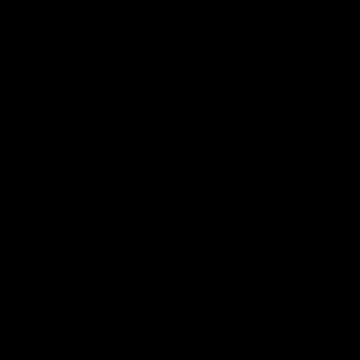
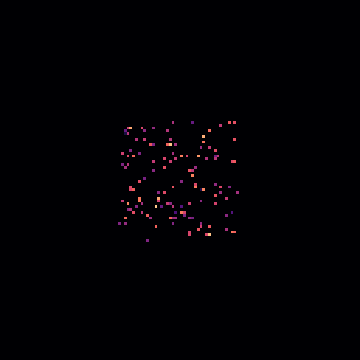
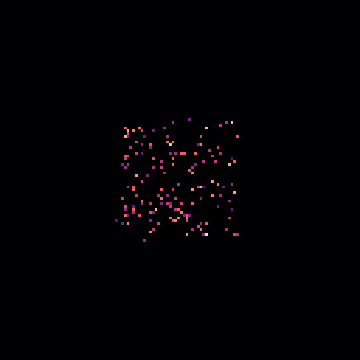
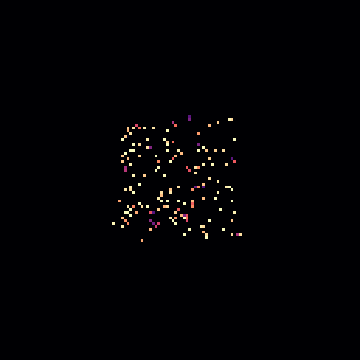
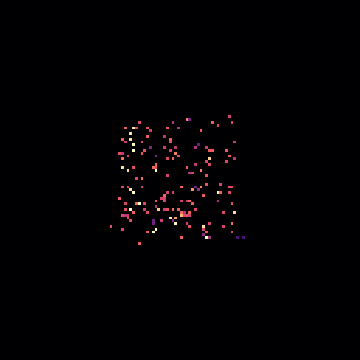
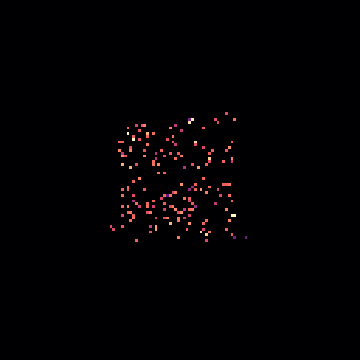
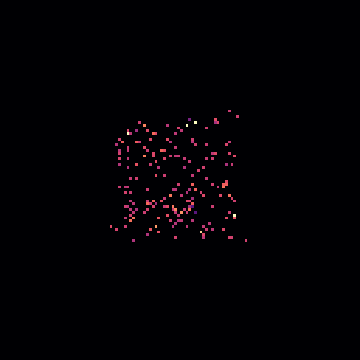
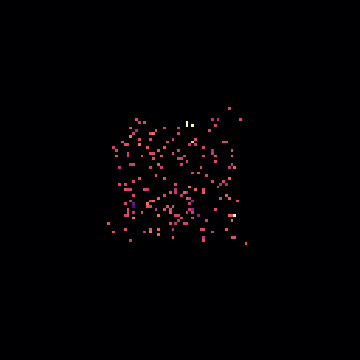
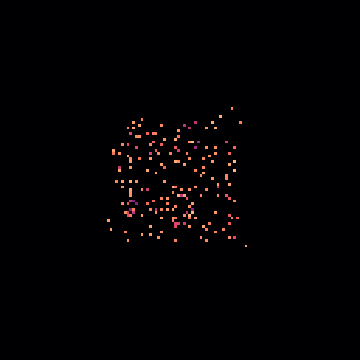
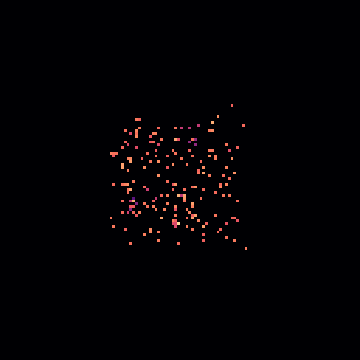
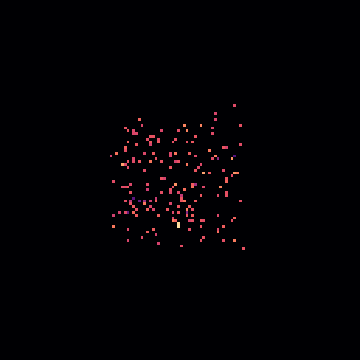
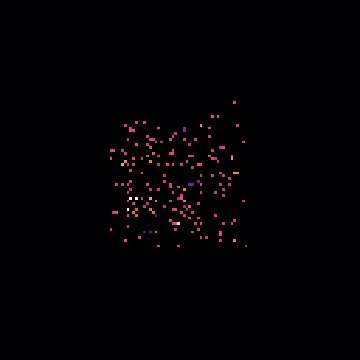
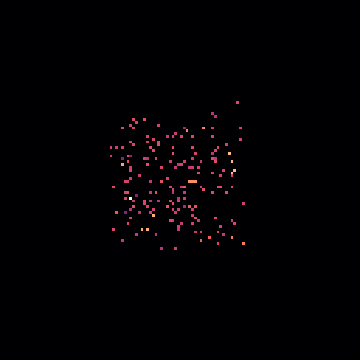
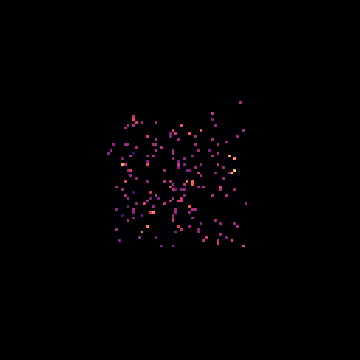
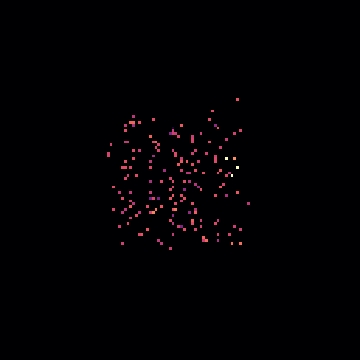
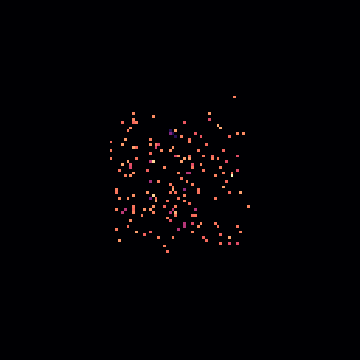
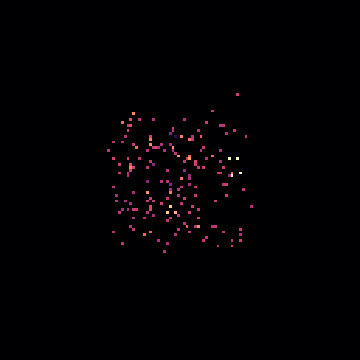
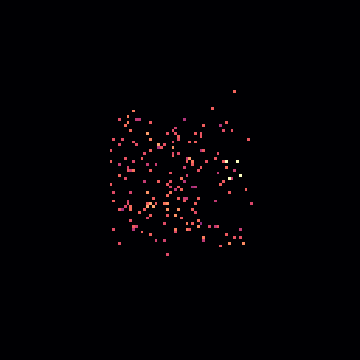
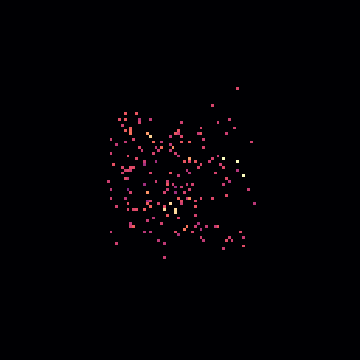
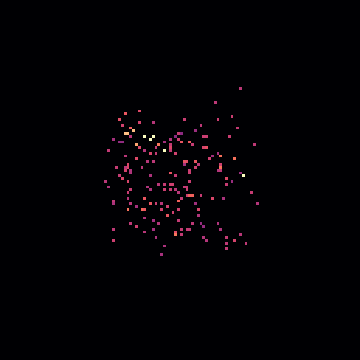
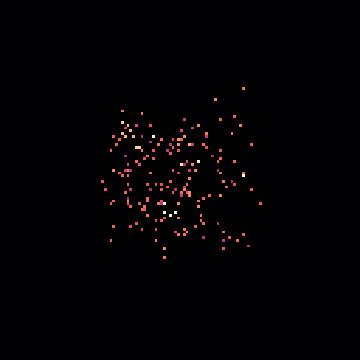
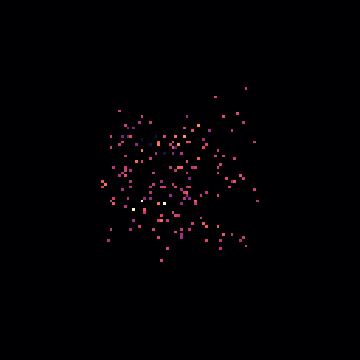
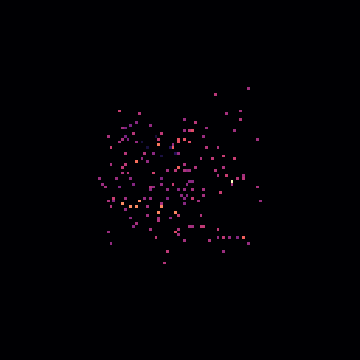
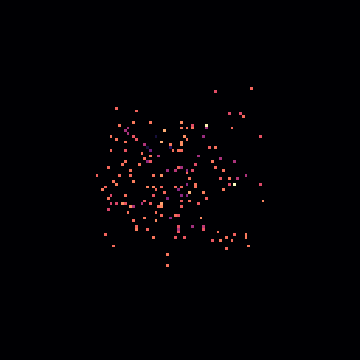
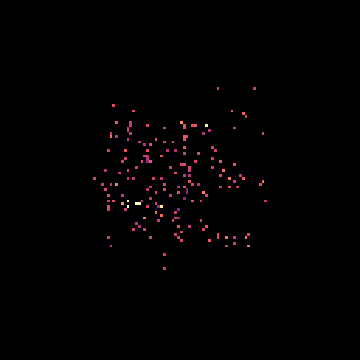
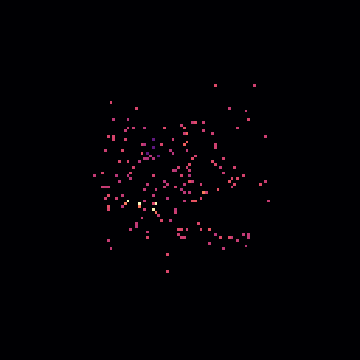
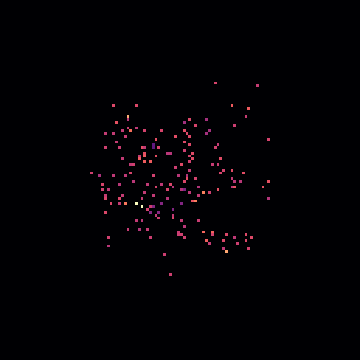
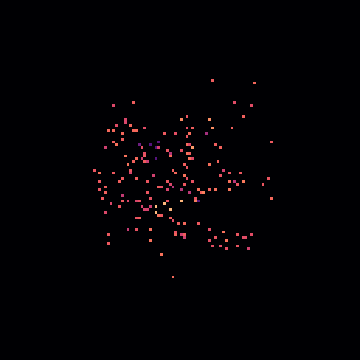
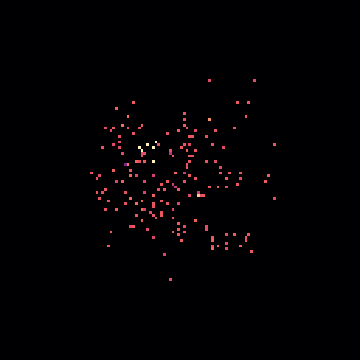
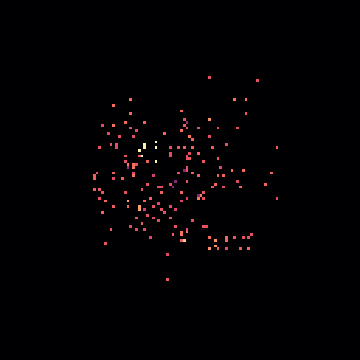
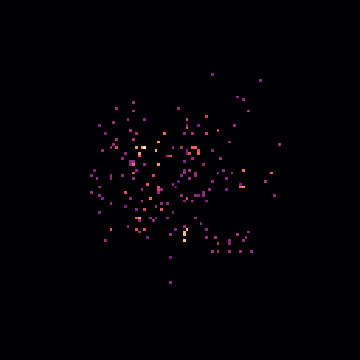
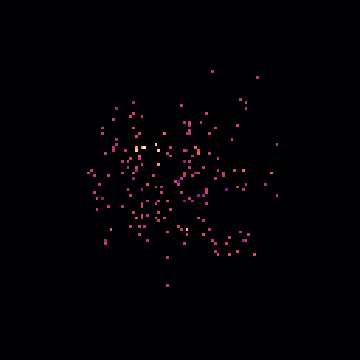
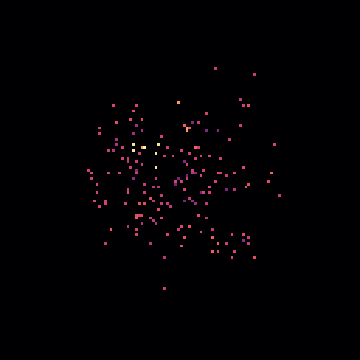
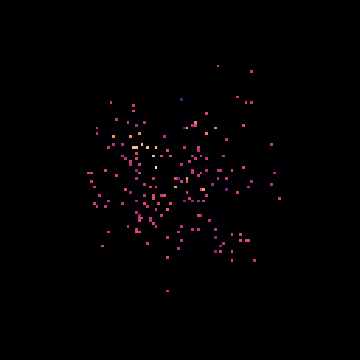
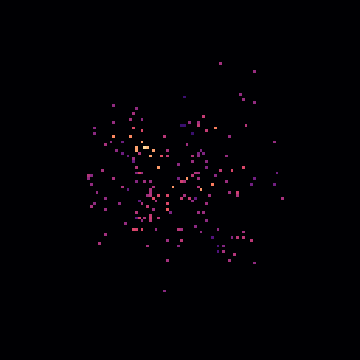
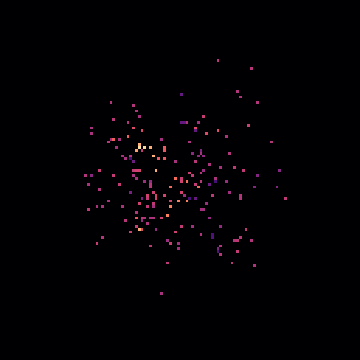
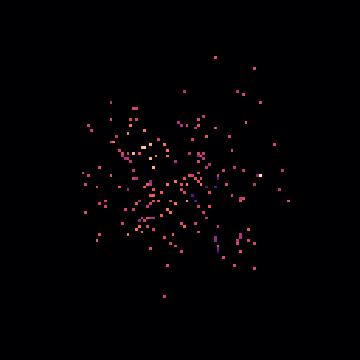
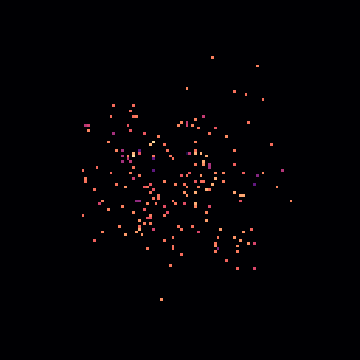
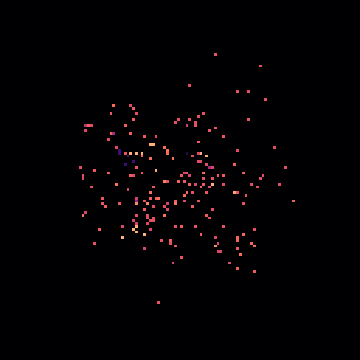
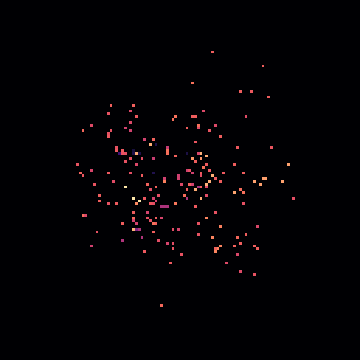
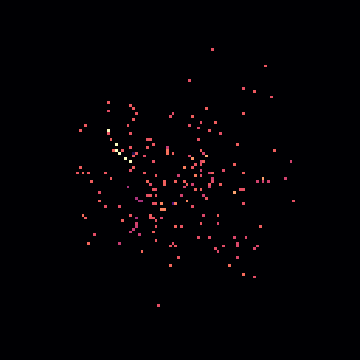
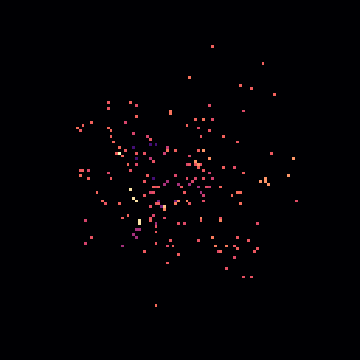
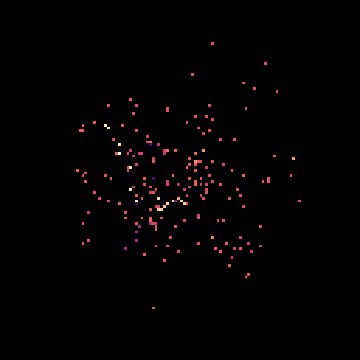
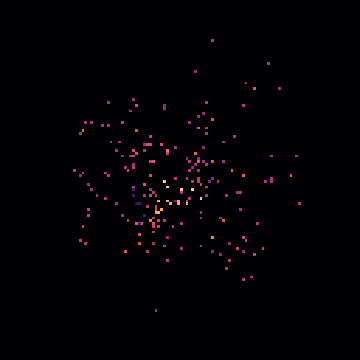
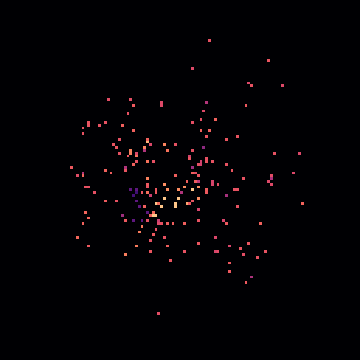
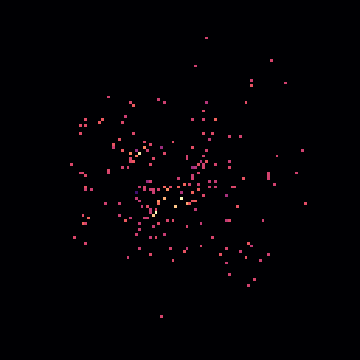
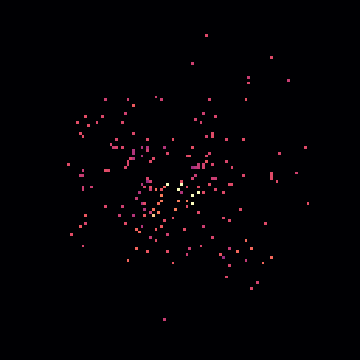
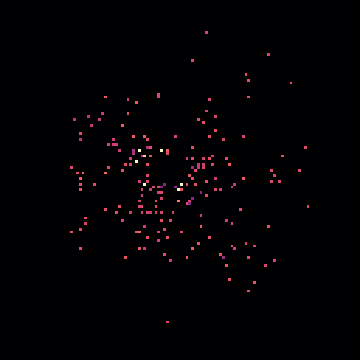
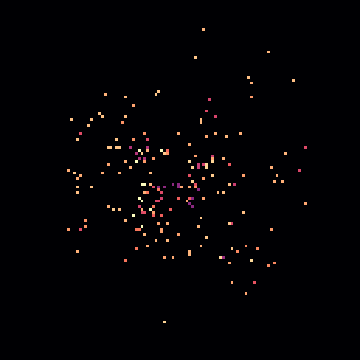
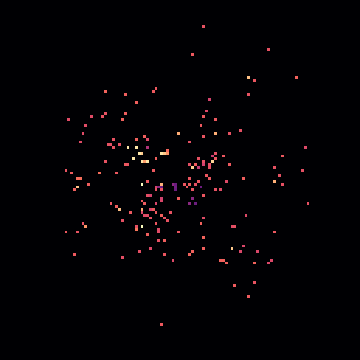
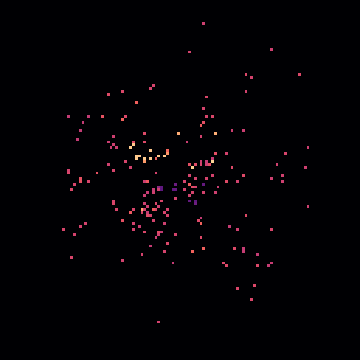
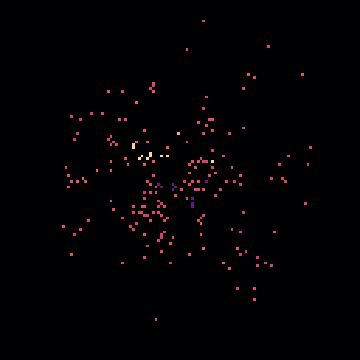
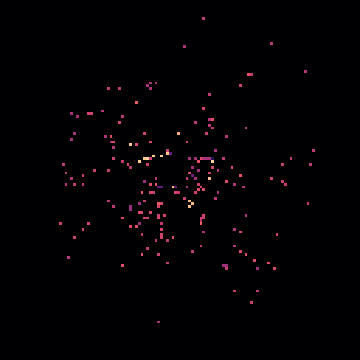
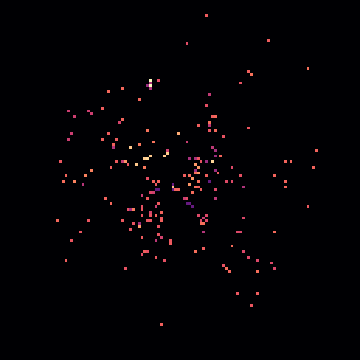
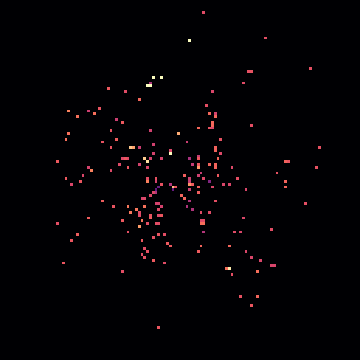
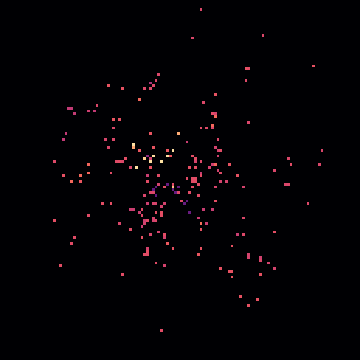
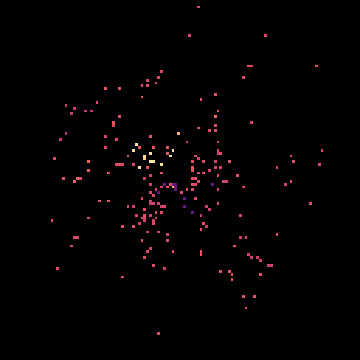
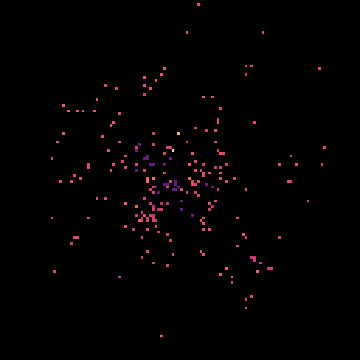
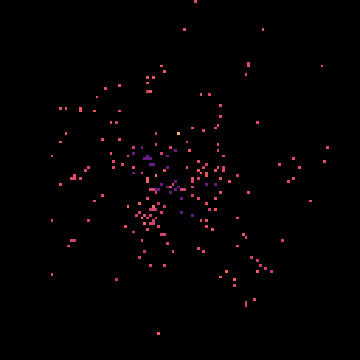
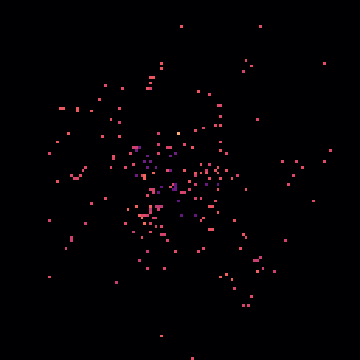
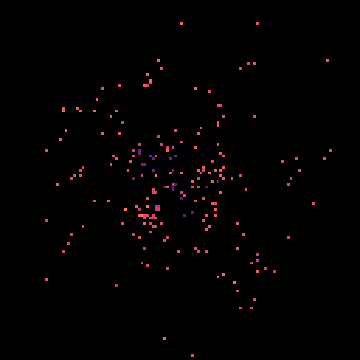
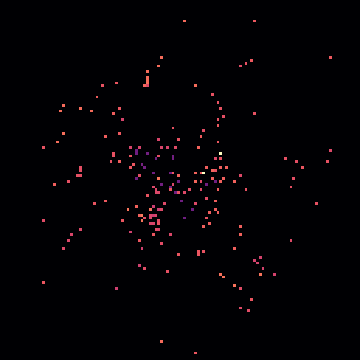
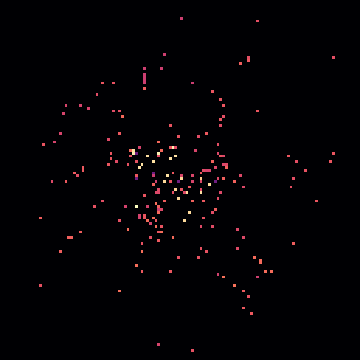
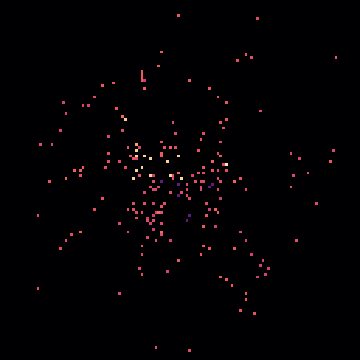
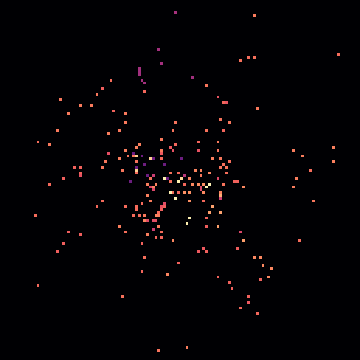
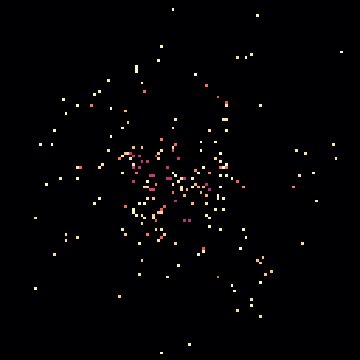
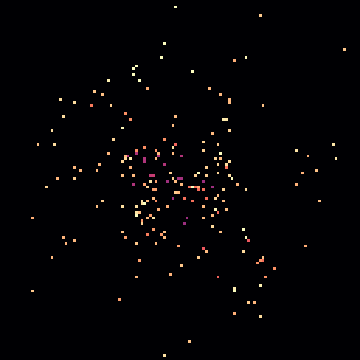
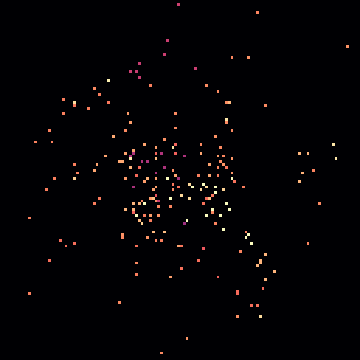
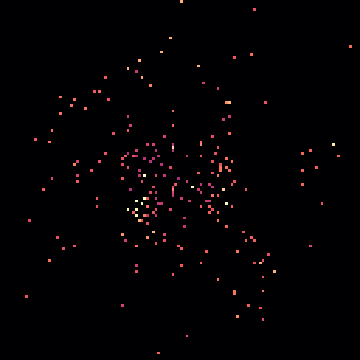
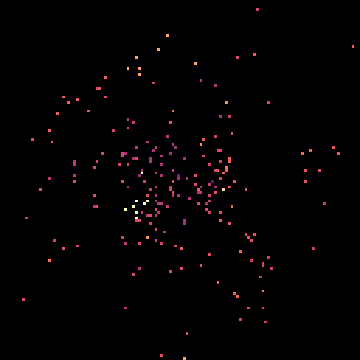
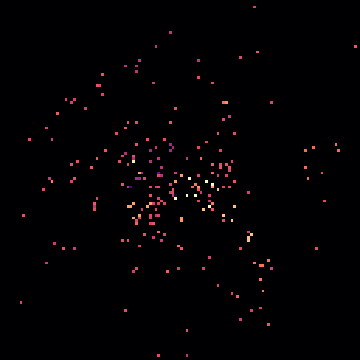
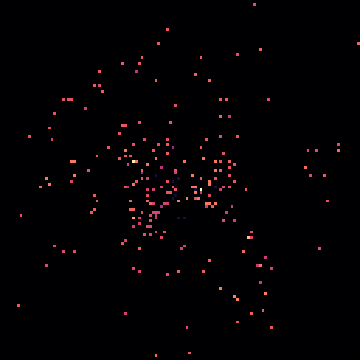
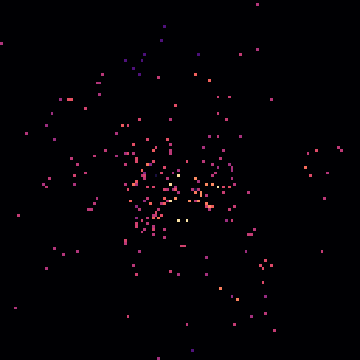
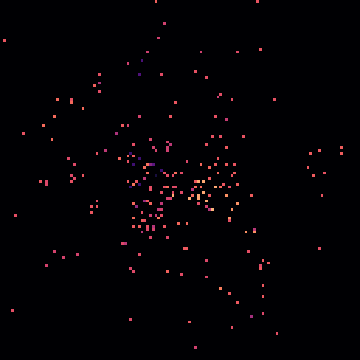
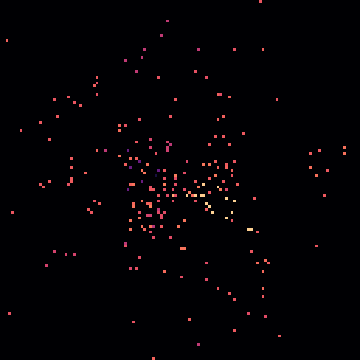
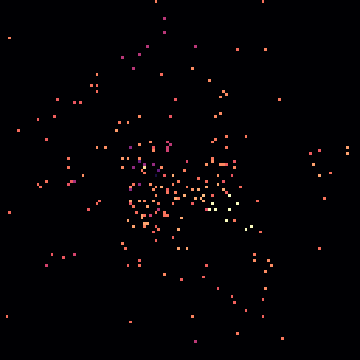
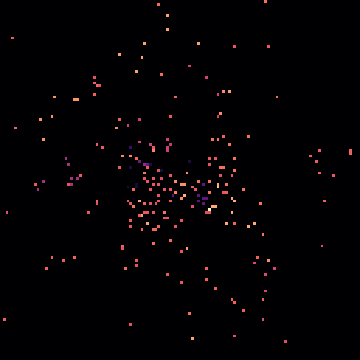
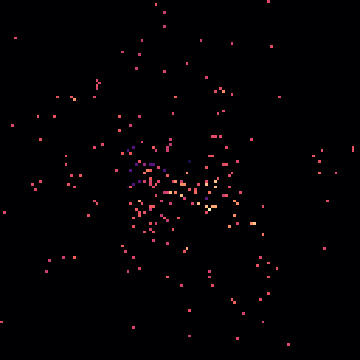
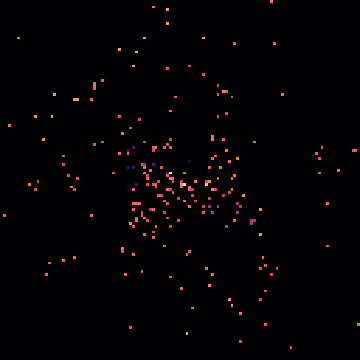
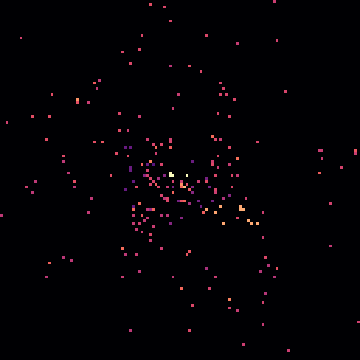
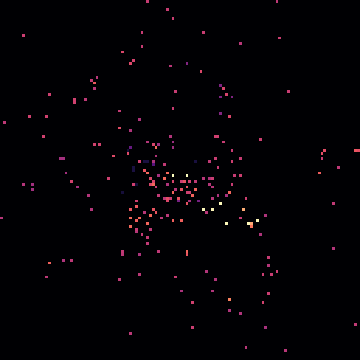
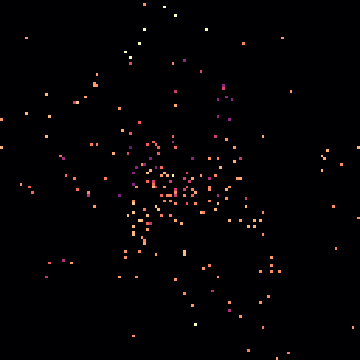
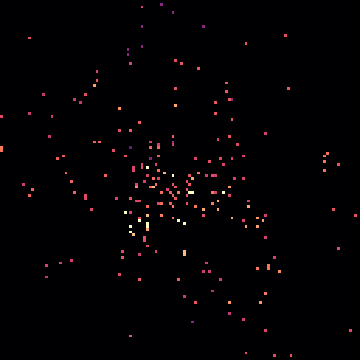
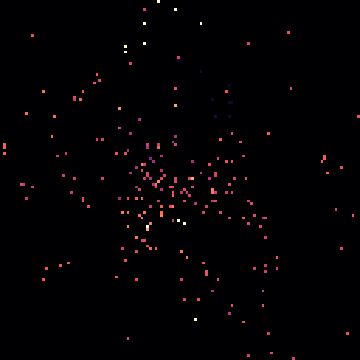
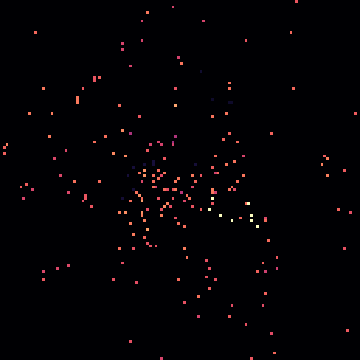
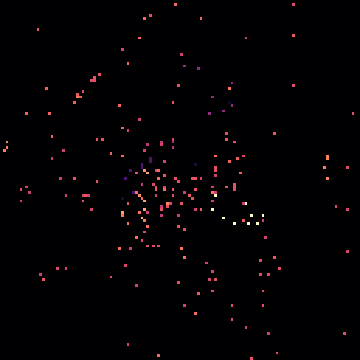
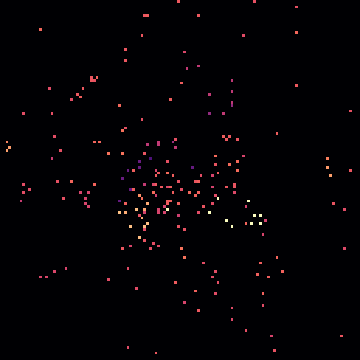
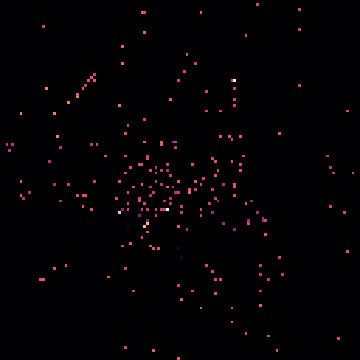
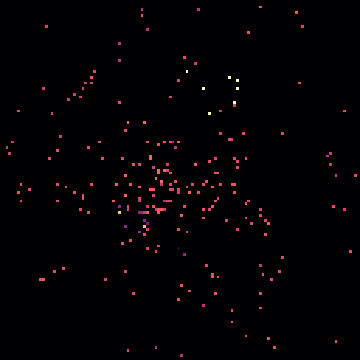
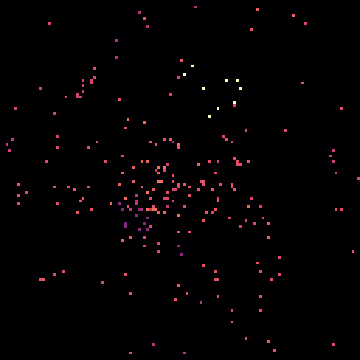
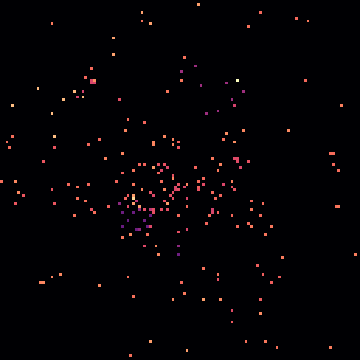
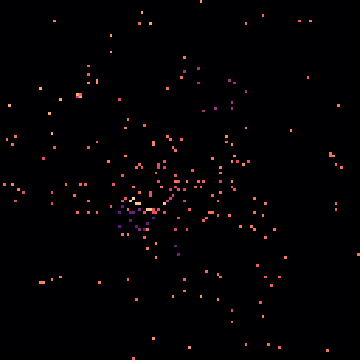
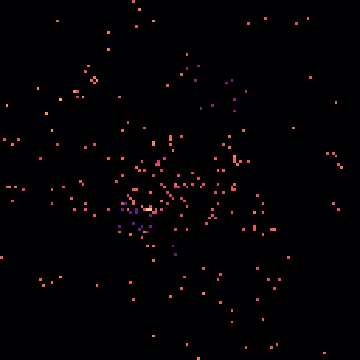
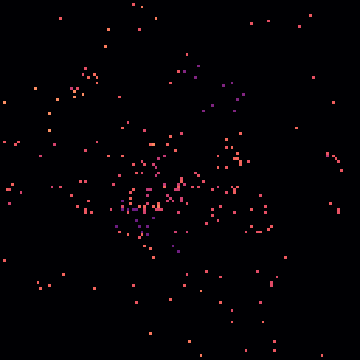
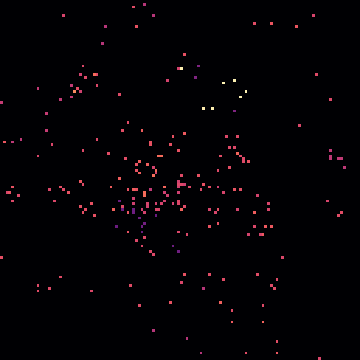
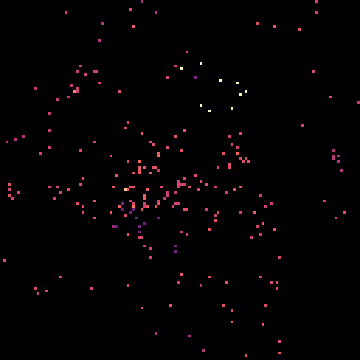
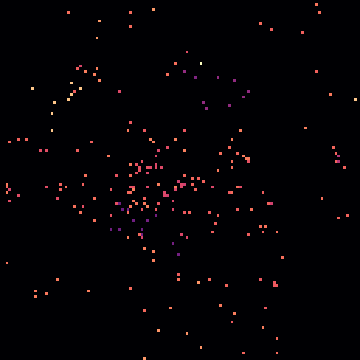
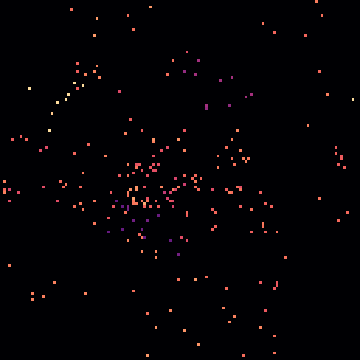
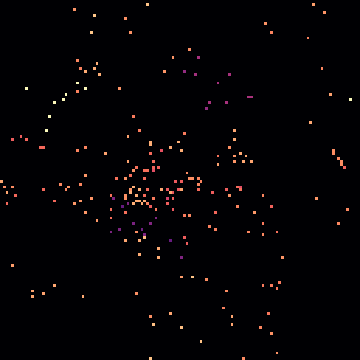
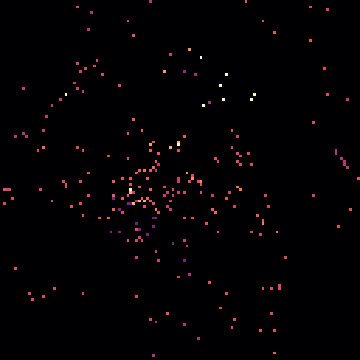

In [9]:
gr

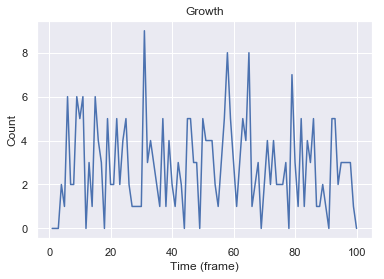

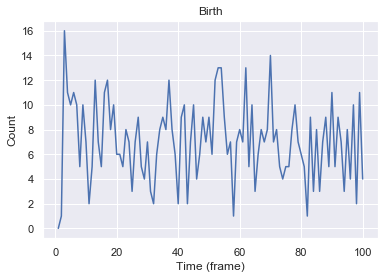

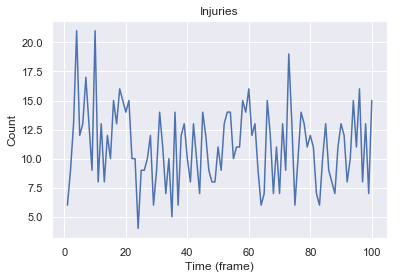

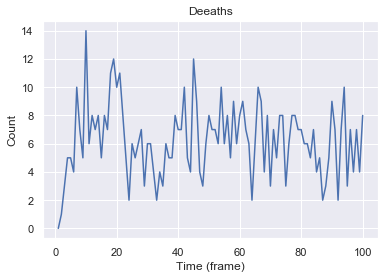

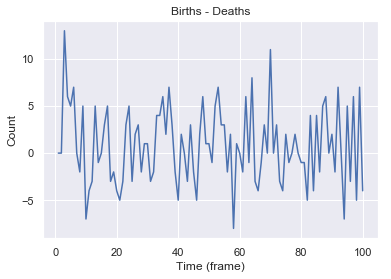

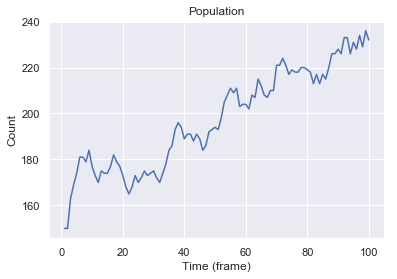

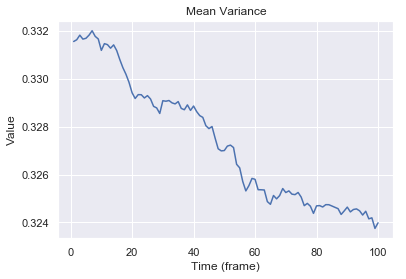

In [10]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [11]:
# Summary
t

array([[  1.        ,   0.        ,   0.        ,   6.        ,
          0.        , 150.        ,   0.33154932],
       [  2.        ,   0.        ,   1.        ,   9.        ,
          1.        , 150.        ,   0.3316228 ],
       [  3.        ,   0.        ,  16.        ,  13.        ,
          3.        , 163.        ,   0.33181335],
       [  4.        ,   2.        ,  11.        ,  21.        ,
          5.        , 169.        ,   0.33164872],
       [  5.        ,   1.        ,  10.        ,  12.        ,
          5.        , 174.        ,   0.33168342],
       [  6.        ,   6.        ,  11.        ,  13.        ,
          4.        , 181.        ,   0.33181495],
       [  7.        ,   2.        ,  10.        ,  17.        ,
         10.        , 181.        ,   0.33199781],
       [  8.        ,   2.        ,   5.        ,  13.        ,
          7.        , 179.        ,   0.33176384],
       [  9.        ,   6.        ,  10.        ,   9.        ,
          5.    

In [12]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 860\nNumber of edges: 709\nAverage degree:   1.6488'

***
# Continue with previous results
***

In [13]:
c, cw, fn, db = extract_tribe(c, cw, fn, 5, [0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 2 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 2 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 3 0 0 0 0 0 0 3 0 0 0 0 0 3 0
 0 0 0 0 4 0 1 1 0 0 1 0 0 1 0 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 2 4 0 0 0 1 0 0 0 2 0 0 2 0 0 3 0 2 0 4 0 2 0 0 0 4 0 1 0 3 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 4 0 2 0 0 1 1 0 4 0 0 3 4 0 0 0 1 0 4 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 1 0 1 0 0 0 4 0 1 0 0 0 0 0 0 0 1
 4 1 0 4 0 0 3 4 0 0]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 79, 82, 83, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 131, 133, 135, 137, 138, 139, 141, 143, 145, 146, 148, 149, 150, 151, 152, 153, 155, 156, 157, 1

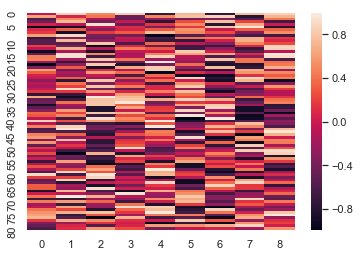

In [14]:
ax = sns.heatmap(cw[0].reshape((sight*sight, 3*3)))

In [16]:
gr, c, cw, fn, g, t, a = slime(frames=500, experimental = True, log = True)

David Newman underwent mitosis.  Gave birth to David Figueroa.
Michael Carney raised hp to 3.0.
Steven Gonzalez underwent mitosis.  Gave birth to Ernest Delacruz.
Cynthia Powell underwent mitosis.  Gave birth to Natalie Gonzales.
Ricardo Brady underwent mitosis.  Gave birth to Alyssa Haynes.
Jerome Barnes raised hp to 3.0.
Matthew Nelson raised hp to 2.0.
We're going extinct, make babies!  Breeding requirements decreased to 5.
Alyssa Williams underwent mitosis.  Gave birth to Adrienne Fleming.
Jennifer Rodriguez attacked Manuel Smith!
Jennifer Rodriguez hp: 8.0 --> 5.0
Manuel Smith hp: 12.0 --> 15.0
Experimental nurture reenforcement modified Jennifer Rodriguez's neural network.
David Moran raised hp to 3.0.
Daniel Dean raised hp to 3.0.
Kyle Arnold attacked David Figueroa!
Kyle Arnold hp: 2.0 --> -1.0
David Figueroa hp: 5.0 --> 8.0
Experimental nurture reenforcement modified Kyle Arnold's neural network.
Kyle Arnold collapsed from injury!.
Mary Kim raised hp to 3.0.
Ricky Davis raised

Anthony Rogers attacked Kyle Kelley!
Anthony Rogers hp: 2.0 --> 0.0
Kyle Kelley hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Anthony Rogers's neural network.
Anthony Rogers collapsed from injury!.
Dr. Jesse Castillo Jr. attacked Gregory Moyer!
Dr. Jesse Castillo Jr. hp: 8.0 --> 10.0
Gregory Moyer hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Dr. Jesse Castillo Jr.'s neural network.
Gregory Moyer collapsed from injury!.
John Jones attacked William Robinson!
John Jones hp: 17.0 --> 19.0
William Robinson hp: 2.0 --> 0.0
Experimental nurture reenforcement modified John Jones's neural network.
William Robinson collapsed from injury!.
Christopher Holloway underwent mitosis.  Gave birth to Deborah Adams.
Larry Norton underwent mitosis.  Gave birth to Lisa Garcia.
Faith Adams attacked Manuel Smith!
Faith Adams hp: 1.0 --> -1.0
Manuel Smith hp: 15.0 --> 17.0
Experimental nurture reenforcement modified Faith Adams's neural network.
Faith Adams collapsed from injury!.

Ruben Bryant attacked Kathleen Wilson!
Ruben Bryant hp: 2.0 --> -1.0
Kathleen Wilson hp: 6.0 --> 9.0
Experimental nurture reenforcement modified Ruben Bryant's neural network.
Ruben Bryant collapsed from injury!.
Julian Herring attacked Christopher Frazier!
Julian Herring hp: 19.0 --> 22.0
Christopher Frazier hp: 5.0 --> 2.0
Experimental nurture reenforcement modified Julian Herring's neural network.
Carolyn Colon attacked Natalie Gallegos!
Carolyn Colon hp: 6.0 --> 3.0
Natalie Gallegos hp: 8.0 --> 11.0
Experimental nurture reenforcement modified Carolyn Colon's neural network.
Rhonda Garrett underwent mitosis.  Gave birth to Mark Carter.
Jeffrey Hudson attacked Victor Rodriguez!
Jeffrey Hudson hp: 1.0 --> 0.0
Victor Rodriguez hp: 8.0 --> 9.0
Experimental nurture reenforcement modified Jeffrey Hudson's neural network.
Jeffrey Hudson collapsed from injury!.
Debra Key raised hp to 2.0.
Holly Johnson attacked Tiffany Vazquez!
Holly Johnson hp: 2.0 --> 0.0
Tiffany Vazquez hp: 6.0 --> 8.0
E

Shannon Herring raised hp to 2.0.
Richard Adams raised hp to 2.0.
Devin Nelson attacked Lee Rodgers!
Devin Nelson hp: 1.0 --> 2.0
Lee Rodgers hp: 1.0 --> 0.0
Experimental nurture reenforcement modified Devin Nelson's neural network.
Lee Rodgers collapsed from injury!.
Shelley Reyes attacked Melissa Dixon!
Shelley Reyes hp: 2.0 --> 4.0
Melissa Dixon hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Shelley Reyes's neural network.
Melissa Dixon collapsed from injury!.
Adam Kline underwent mitosis.  Gave birth to Christopher Hood.
Amy Walter raised hp to 2.0.
Michelle Rodriguez attacked Matthew Nelson!
Michelle Rodriguez hp: 1.0 --> 0.0
Matthew Nelson hp: 2.0 --> 3.0
Experimental nurture reenforcement modified Michelle Rodriguez's neural network.
Michelle Rodriguez collapsed from injury!.
Samantha Warner collapsed from old age!.
Samantha Warner died at age 112.0.
Michelle Frederick died at age 105.0.
Kelly Thomas died at age 100.0.
Rebecca Barber died at age 78.0.
Jason Maxwell 

Tiffany Vazquez attacked Joshua Morris!
Tiffany Vazquez hp: 4.0 --> 2.0
Joshua Morris hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Tiffany Vazquez's neural network.
Gilbert Pena attacked Christopher Brown!
Gilbert Pena hp: 14.0 --> 16.0
Christopher Brown hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Gilbert Pena's neural network.
Christopher Brown collapsed from injury!.
Julian Herring underwent mitosis.  Gave birth to Michael Watkins.
Desiree Briggs raised hp to 2.0.
Brandi Marquez underwent mitosis.  Gave birth to Janice Parker.
Matthew Nelson underwent mitosis.  Gave birth to Penny Harris.
Jennifer Campbell attacked Erin Flores!
Jennifer Campbell hp: 2.0 --> 3.0
Erin Flores hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Jennifer Campbell's neural network.
Julie Peterson raised hp to 2.0.
Natalie Gallegos attacked Rebecca Miller!
Natalie Gallegos hp: 13.0 --> 16.0
Rebecca Miller hp: 3.0 --> 0.0
Experimental nurture reenforcement modified Na

Ashley Richard raised hp to 2.0.
Joshua Morris underwent mitosis.  Gave birth to Michael Mcknight.
Aaron Allen attacked Lori Patterson!
Aaron Allen hp: 2.0 --> 3.0
Lori Patterson hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Aaron Allen's neural network.
Angela Anderson underwent mitosis.  Gave birth to Tonya Oliver.
Elizabeth Garza underwent mitosis.  Gave birth to Jason Cochran.
Tommy Williams attacked Alec Smith!
Tommy Williams hp: 1.0 --> -1.0
Alec Smith hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Tommy Williams's neural network.
Tommy Williams collapsed from injury!.
Jessica Bailey attacked Colleen Day!
Jessica Bailey hp: 4.0 --> 6.0
Colleen Day hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Jessica Bailey's neural network.
Colleen Day collapsed from injury!.
Kelly Gray underwent mitosis.  Gave birth to Lawrence Jefferson.
Lacey Walker attacked Hector Rivera!
Lacey Walker hp: 3.0 --> 2.0
Hector Rivera hp: 4.0 --> 5.0
Experimental nurture

Mr. John Johnson DDS underwent mitosis.  Gave birth to Philip Landry.
Stephen Lopez collapsed from old age!.
Brian Skinner died at age 21.0.
James Rowe died at age 18.0.
Bradley Lawson died at age 11.0.
Teresa Hurst died at age 10.0.
Rebecca Hammond died at age 3.0.
Stephen Lopez died at age 103.0.
Michele Jacobson underwent mitosis.  Gave birth to Kristin Hopkins.
Gerald Glover raised hp to 2.0.
Julian Herring attacked Grant Powell!
Julian Herring hp: 1.0 --> -2.0
Grant Powell hp: 2.0 --> 5.0
Experimental nurture reenforcement modified Julian Herring's neural network.
Julian Herring collapsed from injury!.
Molly Johnson underwent mitosis.  Gave birth to Matthew Williams.
Johnathan Wall attacked Leslie Yoder!
Johnathan Wall hp: 3.0 --> 3.0
Leslie Yoder hp: 3.0 --> 3.0
Experimental nurture reenforcement modified Johnathan Wall's neural network.
Erin Flores underwent mitosis.  Gave birth to Alexis Williamson.
Paul Bowman raised hp to 2.0.
Peter Ortiz attacked Alexandra Jones!
Peter Ortiz

Angela Anderson died at age 27.0.
Elizabeth Garza died at age 27.0.
Wendy Nguyen died at age 12.0.
Scott Booth died at age 108.0.
Susan Mays died at age 3.0.
Mary Kim died at age 103.0.
Patricia Flowers died at age 76.0.
Matthew Carter died at age 30.0.
Bradley Freeman underwent mitosis.  Gave birth to Stephen Martin.
Joshua Morris attacked Adrian Frey!
Joshua Morris hp: 3.0 --> 0.0
Adrian Frey hp: 8.0 --> 11.0
Experimental nurture reenforcement modified Joshua Morris's neural network.
Joshua Morris collapsed from injury!.
Pamela Herrera raised hp to 2.0.
Kathleen Wilson underwent mitosis.  Gave birth to Richard Wilson.
Jessica Bailey raised hp to 2.0.
Gabriella Romero attacked Nicole Golden!
Gabriella Romero hp: 11.0 --> 14.0
Nicole Golden hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Gabriella Romero's neural network.
Nicole Golden collapsed from injury!.
Melissa Bryant attacked Carl Anderson!
Melissa Bryant hp: 4.0 --> 4.0
Carl Anderson hp: 4.0 --> 4.0
Experimental nu

Madison Morrison attacked Jeanette Murray!
Madison Morrison hp: 2.0 --> 3.0
Jeanette Murray hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Madison Morrison's neural network.
Tim Anderson underwent mitosis.  Gave birth to Kevin Bailey.
Natalie Gallegos underwent mitosis.  Gave birth to Jackie Caldwell.
Jeanette Murray attacked Madison Morrison!
Jeanette Murray hp: 1.0 --> -1.0
Madison Morrison hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Jeanette Murray's neural network.
Jeanette Murray collapsed from injury!.
Kyle Hunt underwent mitosis.  Gave birth to Steven Powers.
Allison Riggs raised hp to 2.0.
Philip Landry underwent mitosis.  Gave birth to Rebecca Armstrong.
Stephen Martin raised hp to 2.0.
Randy Coffey underwent mitosis.  Gave birth to Samantha Fox.
Caitlin Mills attacked Michael Watkins!
Caitlin Mills hp: 6.0 --> 5.0
Michael Watkins hp: 15.0 --> 16.0
Experimental nurture reenforcement modified Caitlin Mills's neural network.
Jeanette Murray died at a

Christopher Holloway attacked Caitlin Mills!
Christopher Holloway hp: 2.0 --> 2.0
Caitlin Mills hp: 2.0 --> 2.0
Experimental nurture reenforcement modified Christopher Holloway's neural network.
Brandi Marquez attacked Allison Hodge!
Brandi Marquez hp: 3.0 --> 0.0
Allison Hodge hp: 9.0 --> 12.0
Experimental nurture reenforcement modified Brandi Marquez's neural network.
Brandi Marquez collapsed from injury!.
Mark Carter underwent mitosis.  Gave birth to Paul Bray.
Lacey Walker underwent mitosis.  Gave birth to Leslie Schultz.
Teresa Thompson underwent mitosis.  Gave birth to Christopher Butler.
Kara Whitney underwent mitosis.  Gave birth to Terri Smith.
Natasha Glover raised hp to 2.0.
Caitlin Mills attacked Christopher Holloway!
Caitlin Mills hp: 2.0 --> 4.0
Christopher Holloway hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Caitlin Mills's neural network.
Christopher Holloway collapsed from injury!.
Richard Cummings attacked Erin Flores!
Richard Cummings hp: 2.0 --> 4.0


Kelly Gray attacked Frank Freeman DDS!
Kelly Gray hp: 3.0 --> 6.0
Frank Freeman DDS hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Kelly Gray's neural network.
Frank Freeman DDS collapsed from injury!.
Patricia Baker underwent mitosis.  Gave birth to Jonathan Brown.
Brian Jackson attacked Ashley Gonzalez!
Brian Jackson hp: 6.0 --> 3.0
Ashley Gonzalez hp: 10.0 --> 13.0
Experimental nurture reenforcement modified Brian Jackson's neural network.
Charles Garrison raised hp to 2.0.
Kyle Hunt raised hp to 2.0.
Kristy Caldwell underwent mitosis.  Gave birth to Crystal Smith.
Steven Powers raised hp to 2.0.
Shawn Wright attacked Kyle Hunt!
Shawn Wright hp: 1.0 --> 0.0
Kyle Hunt hp: 2.0 --> 3.0
Experimental nurture reenforcement modified Shawn Wright's neural network.
Shawn Wright collapsed from injury!.
David Osborne attacked Christopher Francis!
David Osborne hp: 1.0 --> 2.0
Christopher Francis hp: 1.0 --> 0.0
Experimental nurture reenforcement modified David Osborne's neural ne

Richard Wilson underwent mitosis.  Gave birth to Tammy Weaver.
Benjamin Elliott raised hp to 2.0.
Samantha Fox attacked Natalie Gallegos!
Samantha Fox hp: 6.0 --> 9.0
Natalie Gallegos hp: 5.0 --> 2.0
Experimental nurture reenforcement modified Samantha Fox's neural network.
Thomas Meyer attacked Kara Whitney!
Thomas Meyer hp: 2.0 --> 3.0
Kara Whitney hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Thomas Meyer's neural network.
Stephen Valdez attacked Spencer Mckinney!
Stephen Valdez hp: 1.0 --> -1.0
Spencer Mckinney hp: 10.0 --> 12.0
Experimental nurture reenforcement modified Stephen Valdez's neural network.
Stephen Valdez collapsed from injury!.
Sandra Johnson attacked Michael Atkins!
Sandra Johnson hp: 2.0 --> 0.0
Michael Atkins hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Sandra Johnson's neural network.
Sandra Johnson collapsed from injury!.
Denise Mckenzie attacked Patricia Hampton!
Denise Mckenzie hp: 1.0 --> 0.0
Patricia Hampton hp: 2.0 --> 3.0
Expe

Paul Brown attacked Amber Kelley!
Paul Brown hp: 2.0 --> -1.0
Amber Kelley hp: 4.0 --> 7.0
Experimental nurture reenforcement modified Paul Brown's neural network.
Paul Brown collapsed from injury!.
Lori Patterson underwent mitosis.  Gave birth to Felicia Rice.
Julie Peterson attacked Brian Hanson!
Julie Peterson hp: 2.0 --> 3.0
Brian Hanson hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Julie Peterson's neural network.
Tim Anderson underwent mitosis.  Gave birth to Rebecca Adams.
Jackie Caldwell attacked Charles Garrison!
Jackie Caldwell hp: 7.0 --> 10.0
Charles Garrison hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Jackie Caldwell's neural network.
Charles Garrison collapsed from injury!.
Samantha Fox attacked Amber Kelley!
Samantha Fox hp: 4.0 --> 1.0
Amber Kelley hp: 7.0 --> 10.0
Experimental nurture reenforcement modified Samantha Fox's neural network.
Justin Hicks raised hp to 2.0.
Don Edwards attacked Alyssa Haynes!
Don Edwards hp: 1.0 --> 0.0
Alyssa 

Caitlin Mills died at age 30.0.
Elizabeth Cook PhD died at age 11.0.
Keith Harris died at age 2.0.
John Mcconnell attacked Jose Newman!
John Mcconnell hp: 2.0 --> 2.0
Jose Newman hp: 2.0 --> 2.0
Experimental nurture reenforcement modified John Mcconnell's neural network.
John Jones attacked Shannon Ortiz!
John Jones hp: 14.0 --> 11.0
Shannon Ortiz hp: 18.0 --> 21.0
Experimental nurture reenforcement modified John Jones's neural network.
Ernest Delacruz underwent mitosis.  Gave birth to Laura Mckay.
Adam Kline underwent mitosis.  Gave birth to Michael Howell.
Kelly Gray attacked Crystal Smith!
Kelly Gray hp: 14.0 --> 12.0
Crystal Smith hp: 16.0 --> 18.0
Experimental nurture reenforcement modified Kelly Gray's neural network.
Christopher Brown raised hp to 2.0.
Rebecca Armstrong attacked Andrew Jones!
Rebecca Armstrong hp: 2.0 --> 0.0
Andrew Jones hp: 3.0 --> 5.0
Experimental nurture reenforcement modified Rebecca Armstrong's neural network.
Rebecca Armstrong collapsed from injury!.
Kenn

Jennifer Boyle attacked Linda Barber!
Jennifer Boyle hp: 2.0 --> 5.0
Linda Barber hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Jennifer Boyle's neural network.
Linda Barber collapsed from injury!.
Emily Simmons attacked Jackie Caldwell!
Emily Simmons hp: 5.0 --> 4.0
Jackie Caldwell hp: 10.0 --> 11.0
Experimental nurture reenforcement modified Emily Simmons's neural network.
Jeffery Green underwent mitosis.  Gave birth to Christopher Jefferson.
Elizabeth Wells died at age 37.0.
Linda Barber died at age 12.0.
Heather Robertson attacked Janice Brown!
Heather Robertson hp: 2.0 --> 0.0
Janice Brown hp: 11.0 --> 13.0
Experimental nurture reenforcement modified Heather Robertson's neural network.
Heather Robertson collapsed from injury!.
Julie Peterson raised hp to 2.0.
Tim Anderson underwent mitosis.  Gave birth to Austin Bird.
Andrew Jones attacked Tricia Nguyen!
Andrew Jones hp: 5.0 --> 8.0
Tricia Nguyen hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Andrew Jo

Austin Bird raised hp to 2.0.
Jeffrey Allen attacked Amber Peters!
Jeffrey Allen hp: 3.0 --> 6.0
Amber Peters hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Jeffrey Allen's neural network.
Amber Peters collapsed from injury!.
Kayla Martinez attacked Christopher Jefferson!
Kayla Martinez hp: 1.0 --> -1.0
Christopher Jefferson hp: 2.0 --> 4.0
Experimental nurture reenforcement modified Kayla Martinez's neural network.
Kayla Martinez collapsed from injury!.
Keith Johnson attacked Michael Howell!
Keith Johnson hp: 2.0 --> 4.0
Michael Howell hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Keith Johnson's neural network.
Michael Howell collapsed from injury!.
Michael Howell died at age 11.0.
Amber Peters died at age 9.0.
Kayla Martinez died at age 2.0.
Frame 70 took 0.6 seconds.
Fernando Peterson underwent mitosis.  Gave birth to Tina Paul.
Robert Donaldson attacked Mr. Gregory Howe DVM!
Robert Donaldson hp: 13.0 --> 15.0
Mr. Gregory Howe DVM hp: 3.0 --> 1.0
Experim

Mr. Andre Mckee PhD underwent mitosis.  Gave birth to Jessica Wise.
Austin Bird attacked William Roberts!
Austin Bird hp: 2.0 --> 3.0
William Roberts hp: 2.0 --> 1.0
Experimental nurture reenforcement modified Austin Bird's neural network.
Alyssa Dunn attacked Spencer Mckinney!
Alyssa Dunn hp: 16.0 --> 19.0
Spencer Mckinney hp: 3.0 --> 0.0
Experimental nurture reenforcement modified Alyssa Dunn's neural network.
Spencer Mckinney collapsed from injury!.
Kimberly Saunders attacked Robert Donaldson!
Kimberly Saunders hp: 7.0 --> 8.0
Robert Donaldson hp: 7.0 --> 6.0
Experimental nurture reenforcement modified Kimberly Saunders's neural network.
Tony Christian attacked Nathan Carlson!
Tony Christian hp: 2.0 --> 0.0
Nathan Carlson hp: 6.0 --> 8.0
Experimental nurture reenforcement modified Tony Christian's neural network.
Tony Christian collapsed from injury!.
Keith Johnson underwent mitosis.  Gave birth to Justin Gordon.
Logan Nichols attacked Karen Kidd!
Logan Nichols hp: 7.0 --> 8.0
Karen

Charles Johnson underwent mitosis.  Gave birth to Julia Foster.
Bradley Dominguez underwent mitosis.  Gave birth to Thomas Norman.
Carly Bennett attacked Kimberly Saunders!
Carly Bennett hp: 2.0 --> 0.0
Kimberly Saunders hp: 13.0 --> 15.0
Experimental nurture reenforcement modified Carly Bennett's neural network.
Carly Bennett collapsed from injury!.
Jessica Wise attacked Tracie Edwards!
Jessica Wise hp: 2.0 --> 5.0
Tracie Edwards hp: 1.0 --> -2.0
Experimental nurture reenforcement modified Jessica Wise's neural network.
Tracie Edwards collapsed from injury!.
Gregory Wood underwent mitosis.  Gave birth to Christopher Hebert.
Elizabeth Bell raised hp to 2.0.
Michael Thompson underwent mitosis.  Gave birth to Karen Taylor.
Kathryn Mayo attacked Lisa Sanchez!
Kathryn Mayo hp: 2.0 --> 0.0
Lisa Sanchez hp: 7.0 --> 9.0
Experimental nurture reenforcement modified Kathryn Mayo's neural network.
Kathryn Mayo collapsed from injury!.
Jessica Miranda died at age 39.0.
Anthony Cox died at age 28.0.

Emily Simmons attacked Sarah Bowen!
Emily Simmons hp: 2.0 --> 0.0
Sarah Bowen hp: 9.0 --> 11.0
Experimental nurture reenforcement modified Emily Simmons's neural network.
Emily Simmons collapsed from injury!.
Jeffery Green underwent mitosis.  Gave birth to James Hull.
Tina Paul underwent mitosis.  Gave birth to Frederick Cunningham.
Leah Roberts underwent mitosis.  Gave birth to Ryan Beasley.
Wendy Smith attacked Jacqueline Fernandez!
Wendy Smith hp: 1.0 --> 3.0
Jacqueline Fernandez hp: 1.0 --> -1.0
Experimental nurture reenforcement modified Wendy Smith's neural network.
Jacqueline Fernandez collapsed from injury!.
Justin Smith attacked Andrew Hensley!
Justin Smith hp: 2.0 --> 4.0
Andrew Hensley hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Justin Smith's neural network.
Andrew Hensley collapsed from injury!.
Jacqueline Fernandez died at age 81.0.
Christopher Brown died at age 64.0.
Leslie Schultz died at age 47.0.
Charles Johnson died at age 24.0.
Emily Simmons died at 

Michelle Cook underwent mitosis.  Gave birth to Michelle Weeks.
Thomas Lewis underwent mitosis.  Gave birth to Janet Bauer.
Kara Boyd underwent mitosis.  Gave birth to Jonathan Wheeler.
Robert Donaldson underwent mitosis.  Gave birth to Jennifer Vaughn.
Lisa Sanchez underwent mitosis.  Gave birth to Christian Ferrell.
Sarah Bowen underwent mitosis.  Gave birth to Julia Lang.
Mr. Dennis West attacked Bradley Dominguez!
Mr. Dennis West hp: 3.0 --> 6.0
Bradley Dominguez hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Mr. Dennis West's neural network.
Bradley Dominguez collapsed from injury!.
Mr. Jonathon Mahoney underwent mitosis.  Gave birth to Christopher Mueller.
Michelle Mercado attacked Jennifer Ward!
Michelle Mercado hp: 3.0 --> 3.0
Jennifer Ward hp: 3.0 --> 3.0
Experimental nurture reenforcement modified Michelle Mercado's neural network.
Anthony Wright attacked Megan Franco!
Anthony Wright hp: 3.0 --> 7.0
Megan Franco hp: 2.0 --> -2.0
Experimental nurture reenforcemen

Elizabeth Carpenter MD raised hp to 2.0.
Brian Hanson underwent mitosis.  Gave birth to Daniel Moore.
Angela Quinn underwent mitosis.  Gave birth to Lisa Alvarado.
Michelle Woodard raised hp to 2.0.
Christopher Jefferson raised hp to 2.0.
Alyssa Dunn attacked Christian Ferrell!
Alyssa Dunn hp: 19.0 --> 21.0
Christian Ferrell hp: 2.0 --> 0.0
Experimental nurture reenforcement modified Alyssa Dunn's neural network.
Christian Ferrell collapsed from injury!.
Albert Wilson raised hp to 2.0.
Michelle Martin attacked April Joseph!
Michelle Martin hp: 3.0 --> 6.0
April Joseph hp: 2.0 --> -1.0
Experimental nurture reenforcement modified Michelle Martin's neural network.
April Joseph collapsed from injury!.
Nathan Carlson underwent mitosis.  Gave birth to Edward Tran.
Sarah Bowen underwent mitosis.  Gave birth to Christopher Smith.
Michelle Mercado raised hp to 2.0.
Mr. Michael Oneal underwent mitosis.  Gave birth to Edward Powell.
Daniel Johnson raised hp to 2.0.
Christopher Mueller attacked Le

Total Run Time:  83.6 seconds.



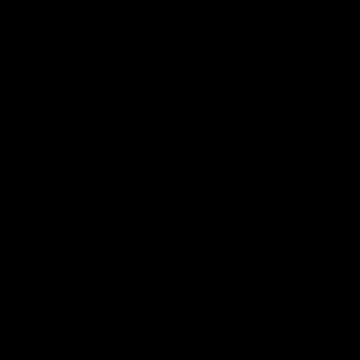
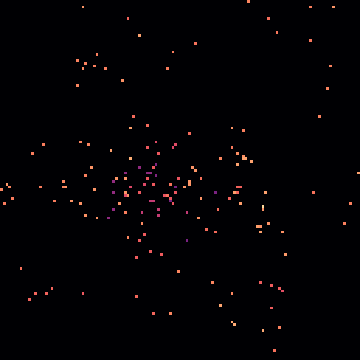
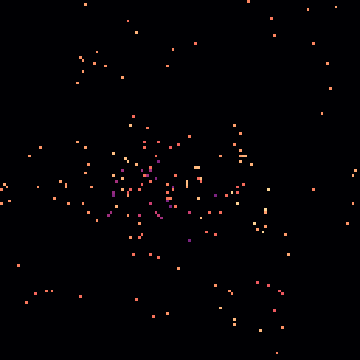
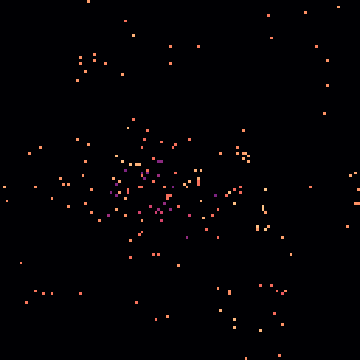
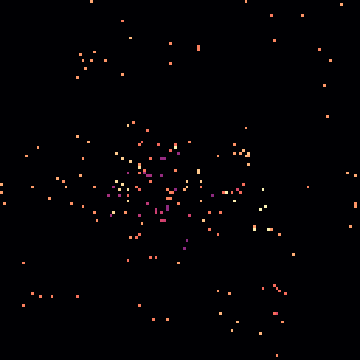
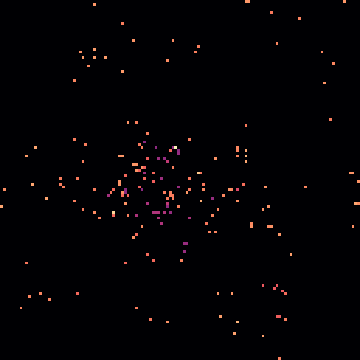
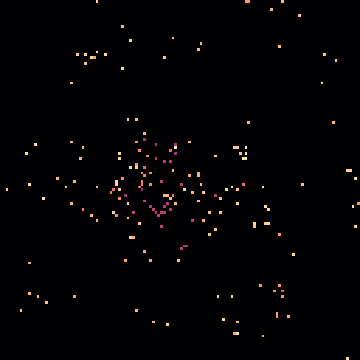
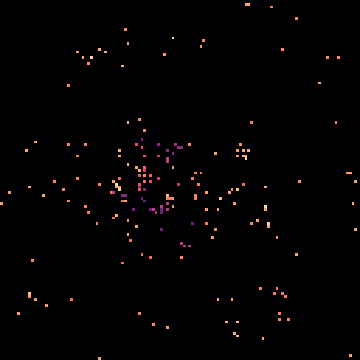
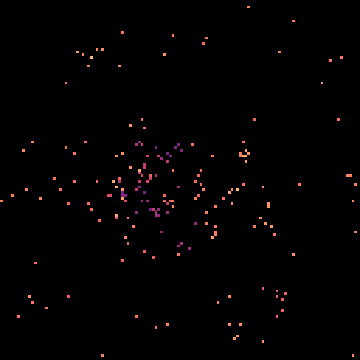
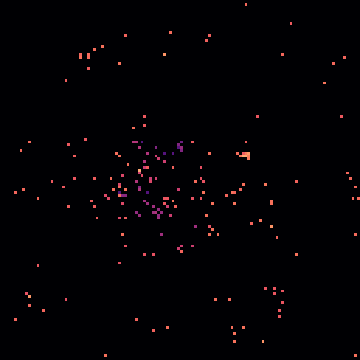
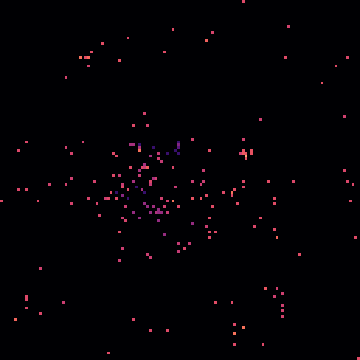
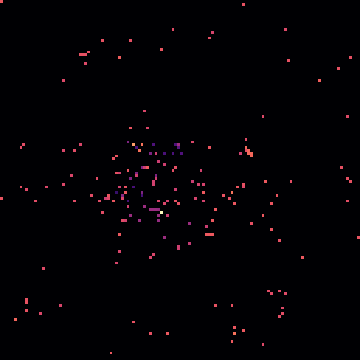
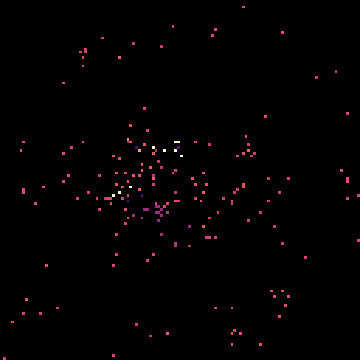
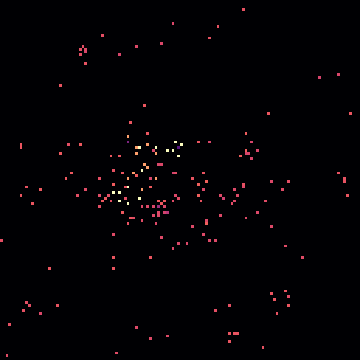
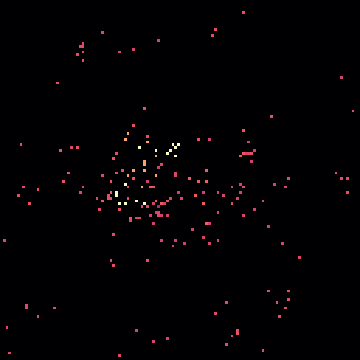
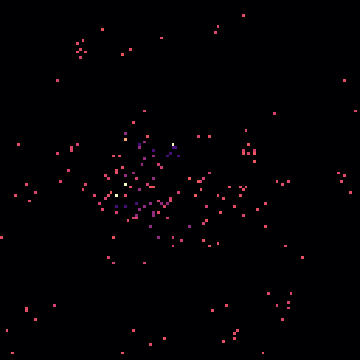
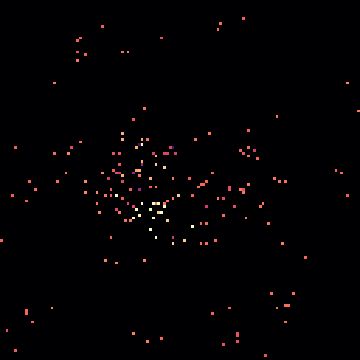
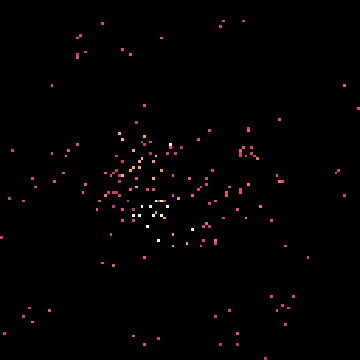
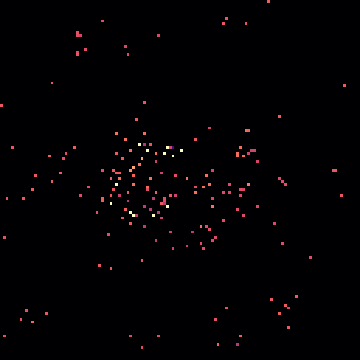
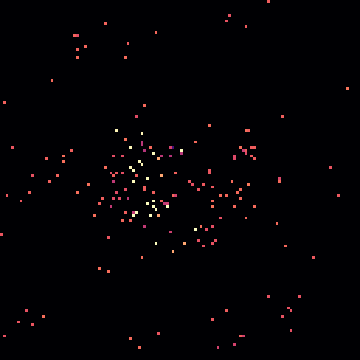
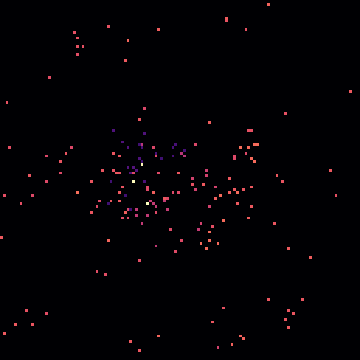
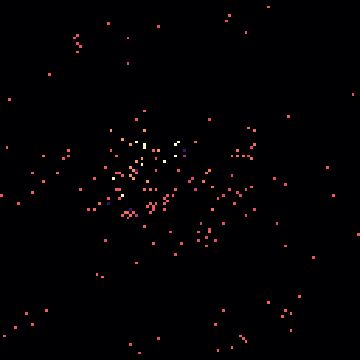
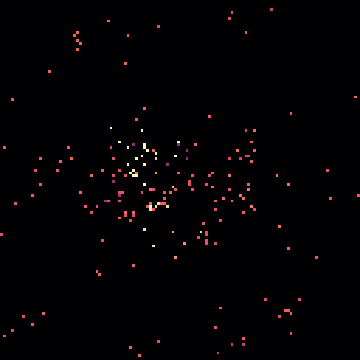
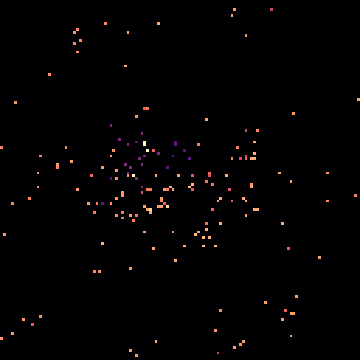
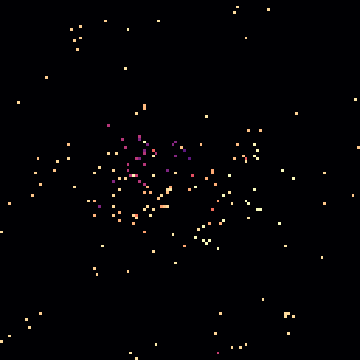
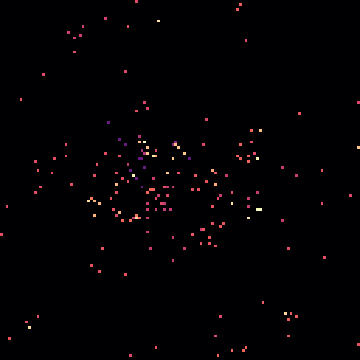
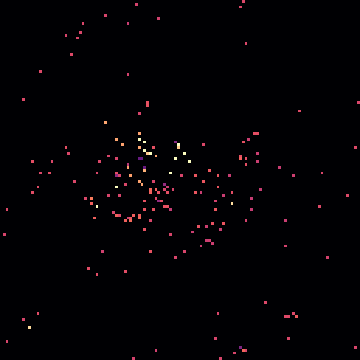
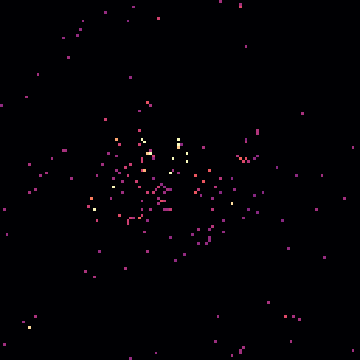
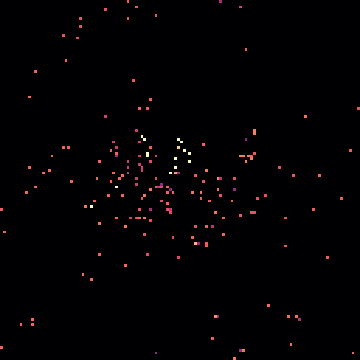
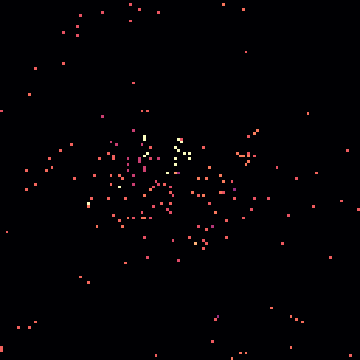
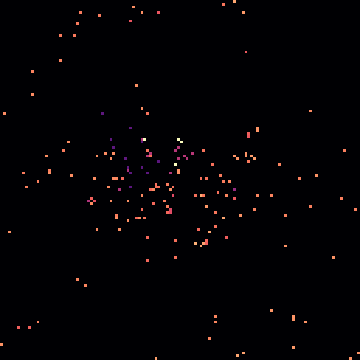
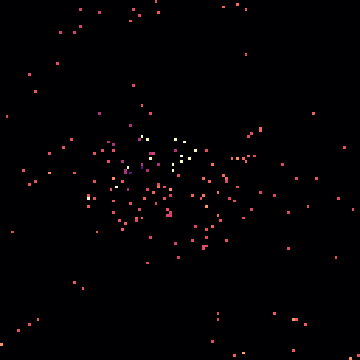
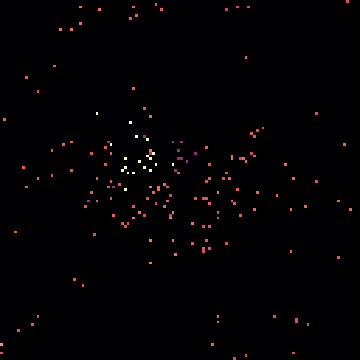
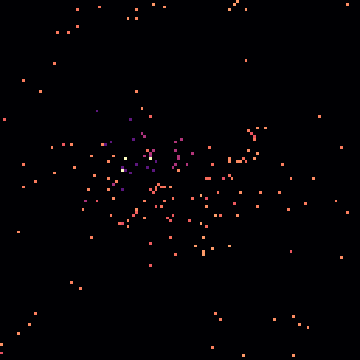
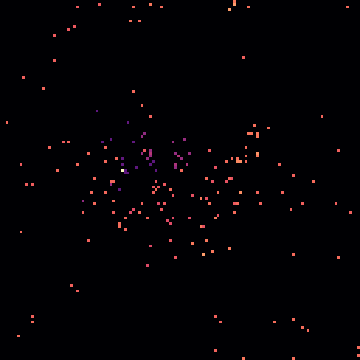
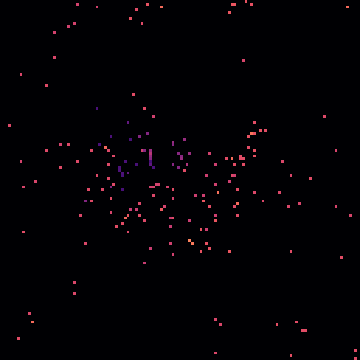
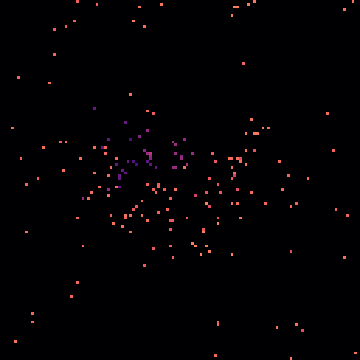
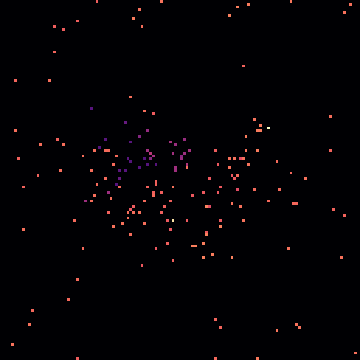
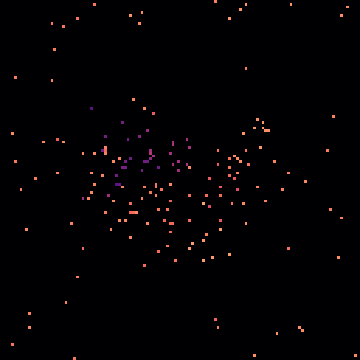
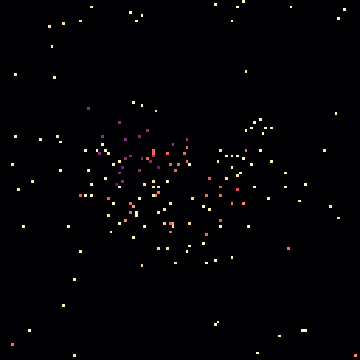
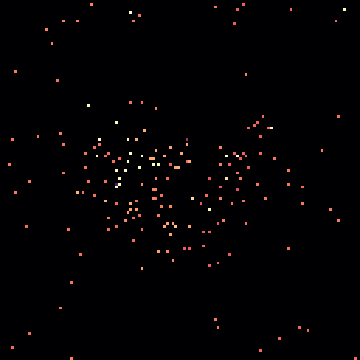
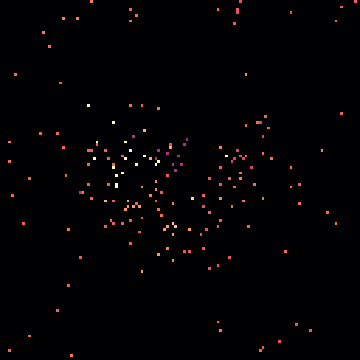
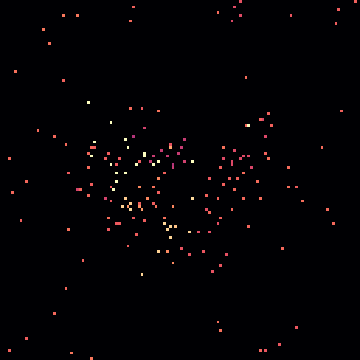
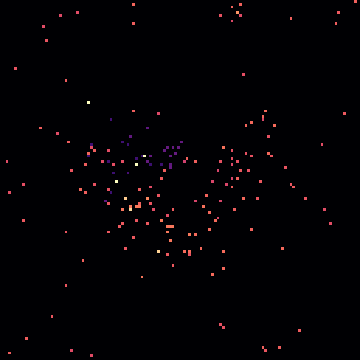
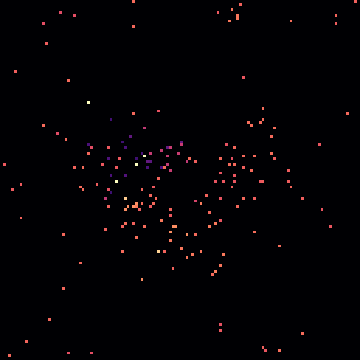
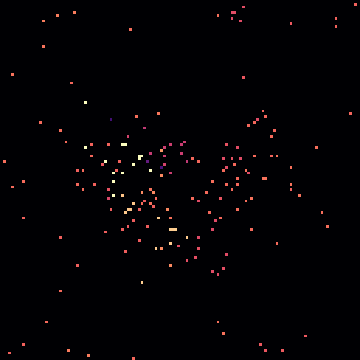
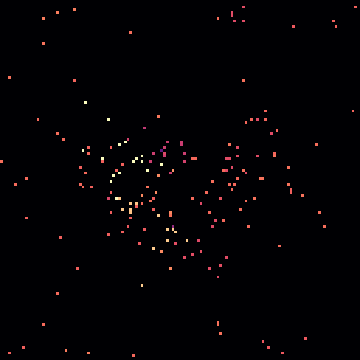
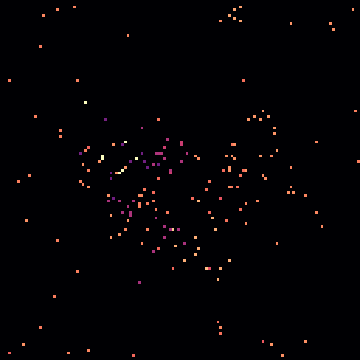
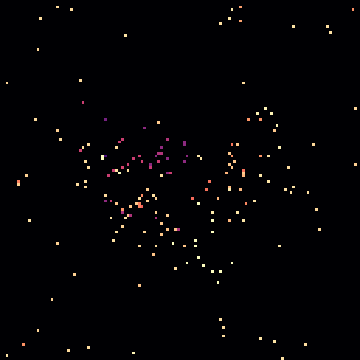
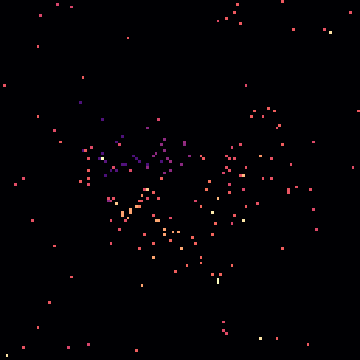
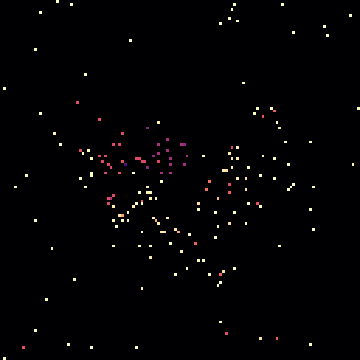
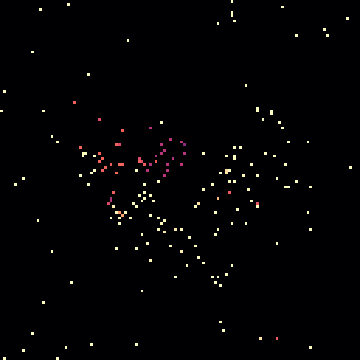
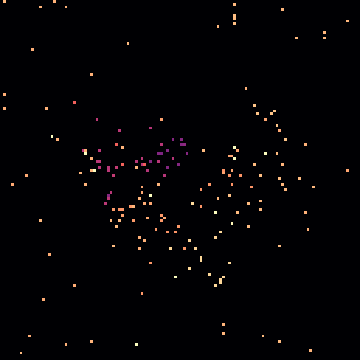
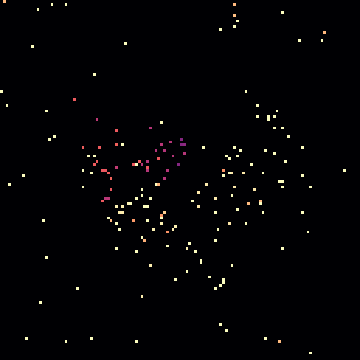
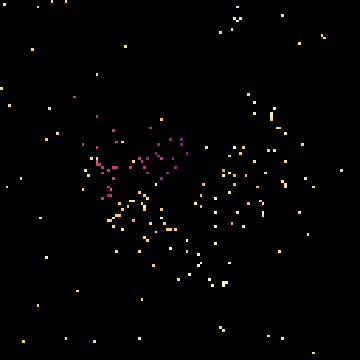
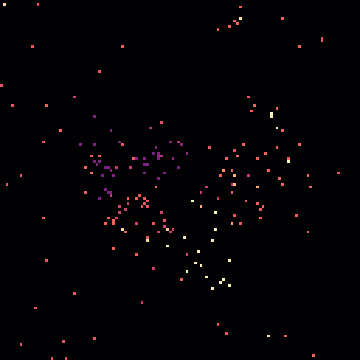
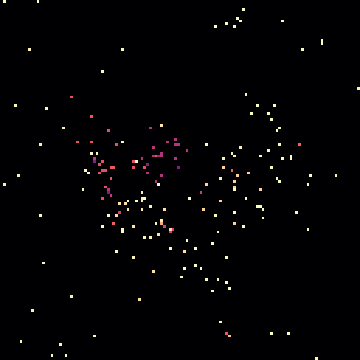
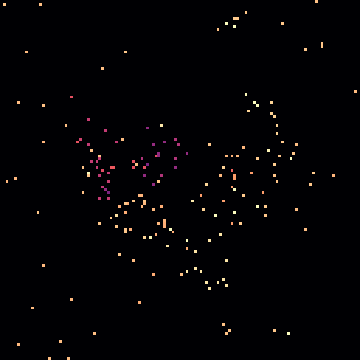
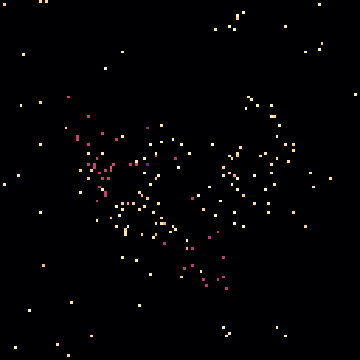
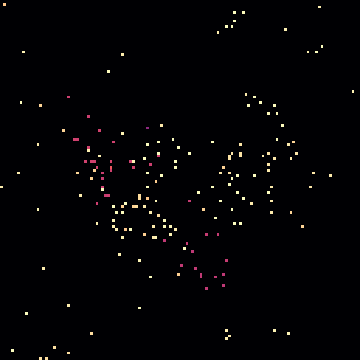
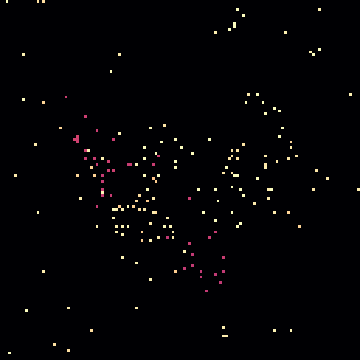
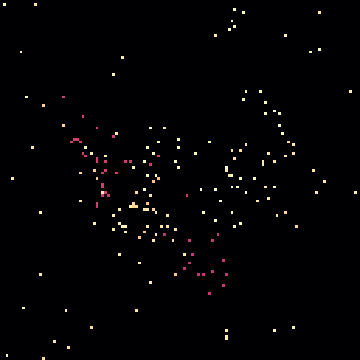
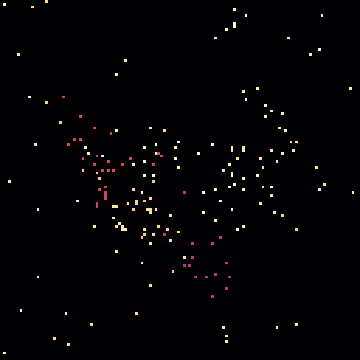
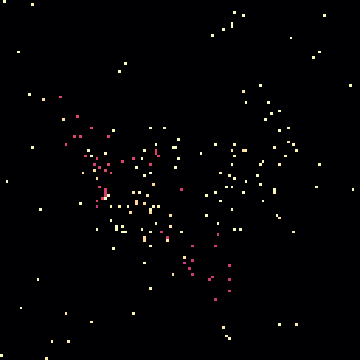
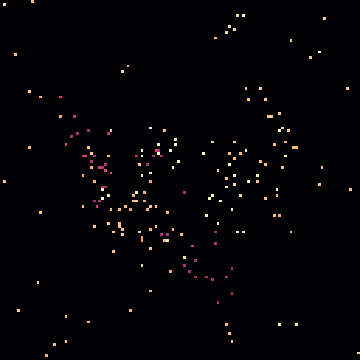
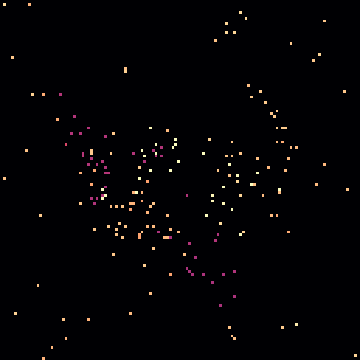
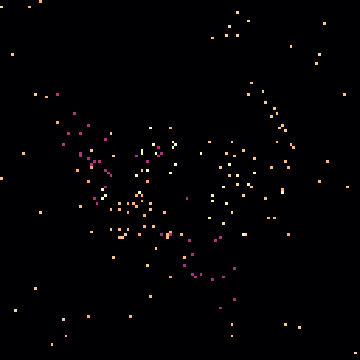
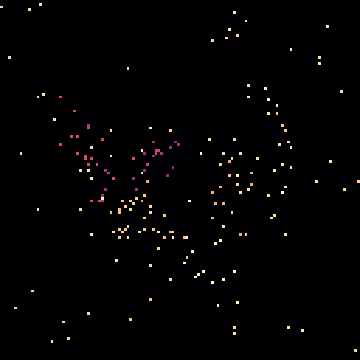
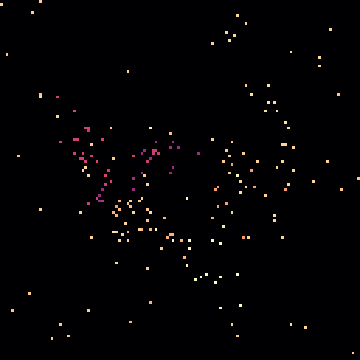
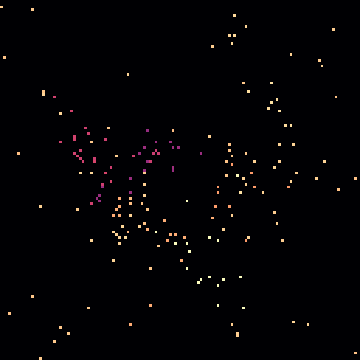
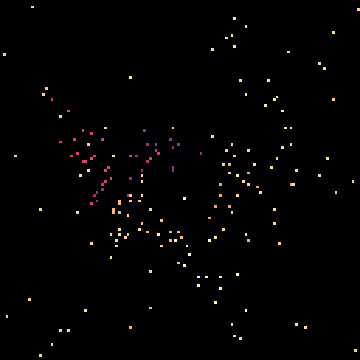
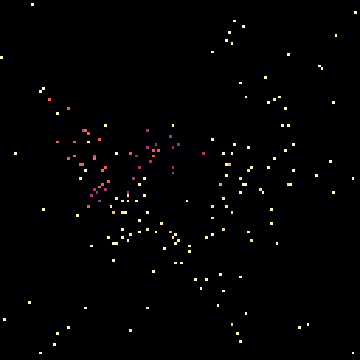
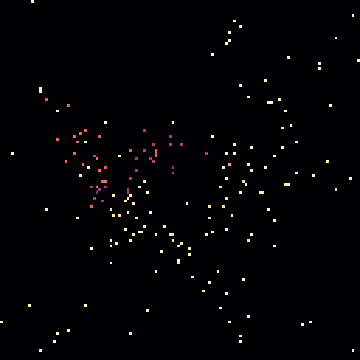
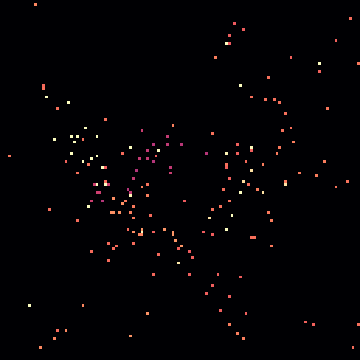
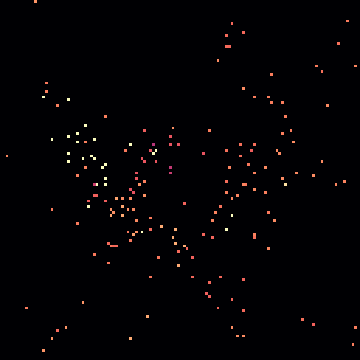
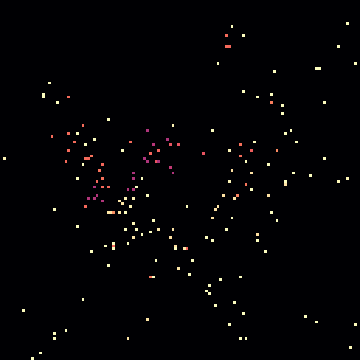
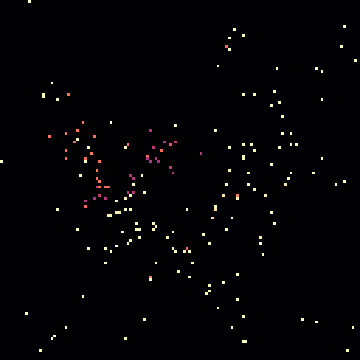
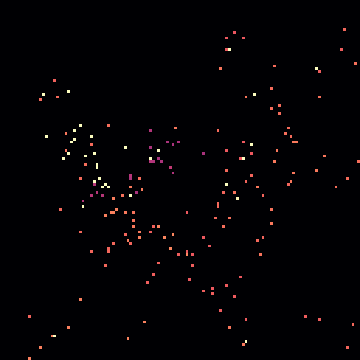
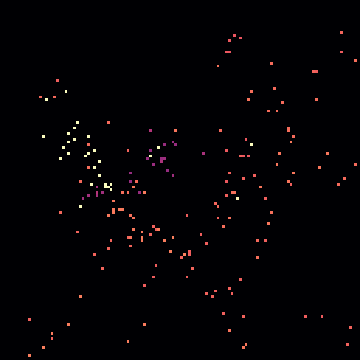
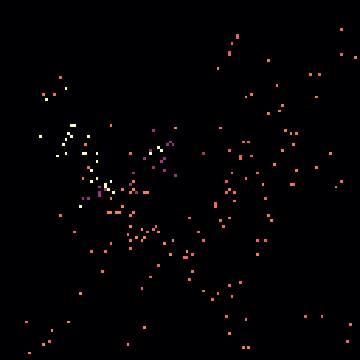
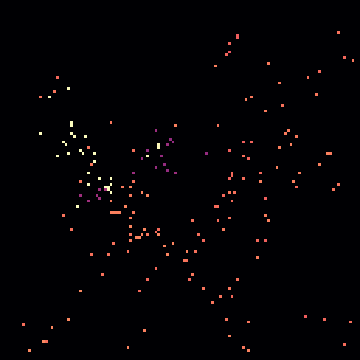
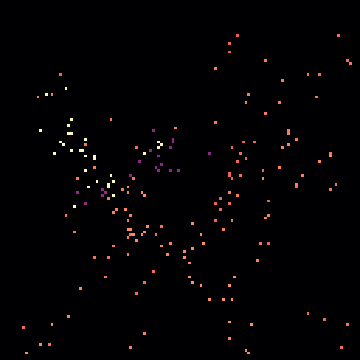
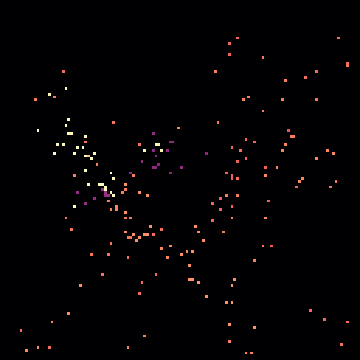
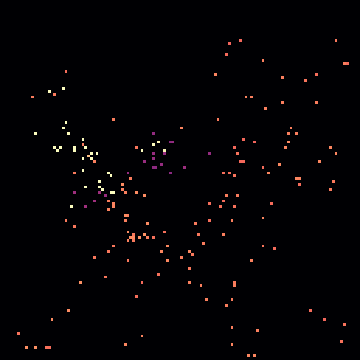
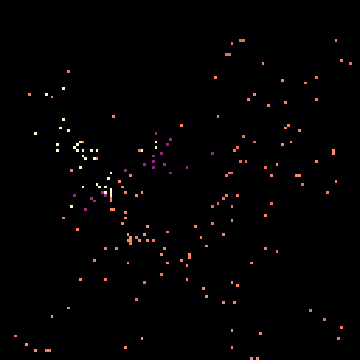
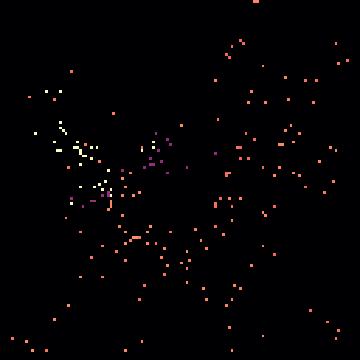
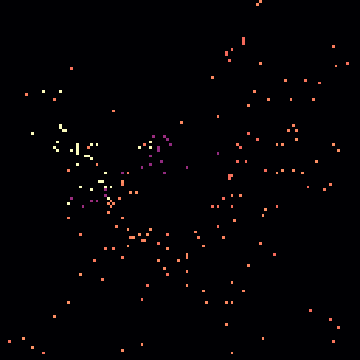
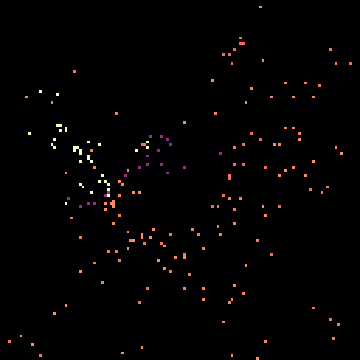
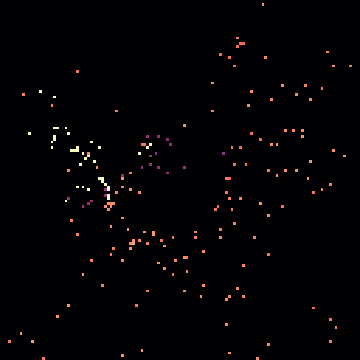
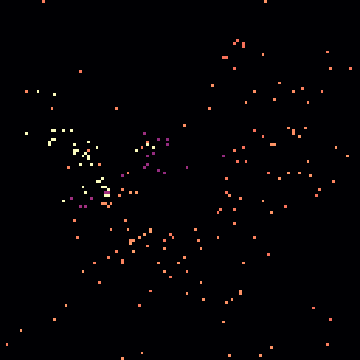
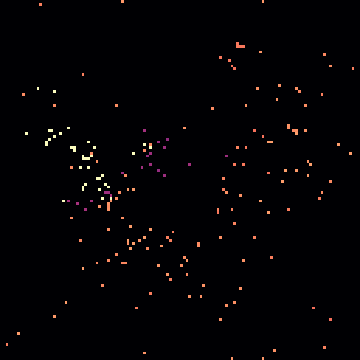
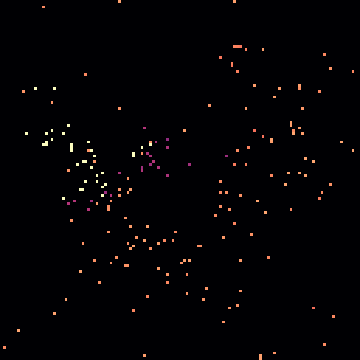
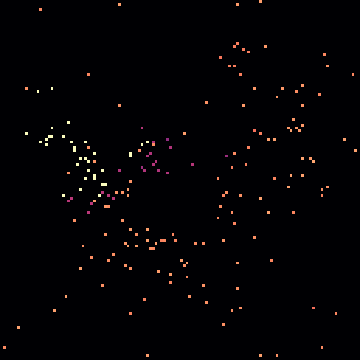
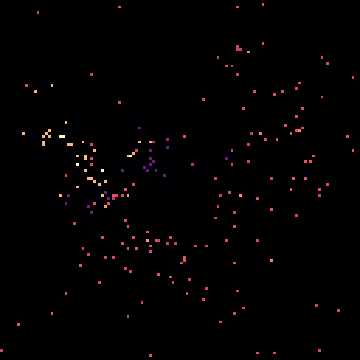
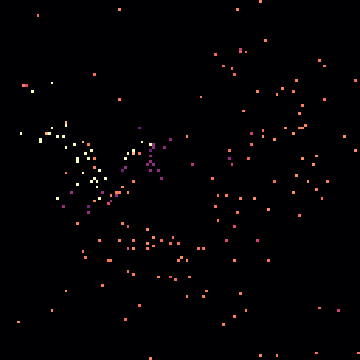
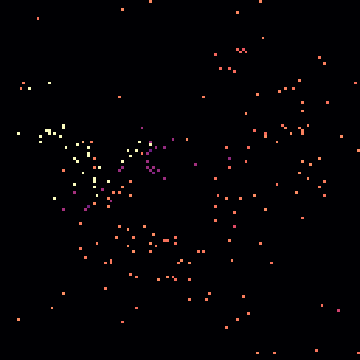
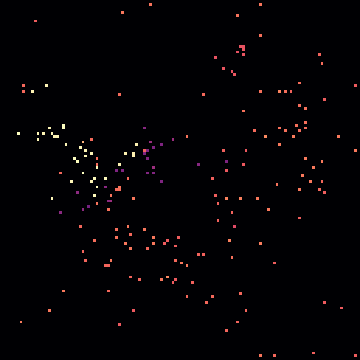
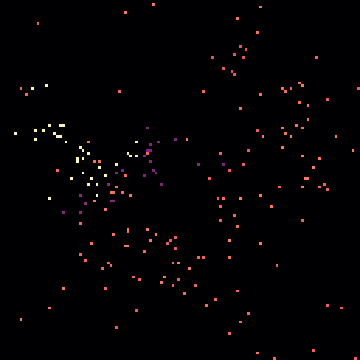
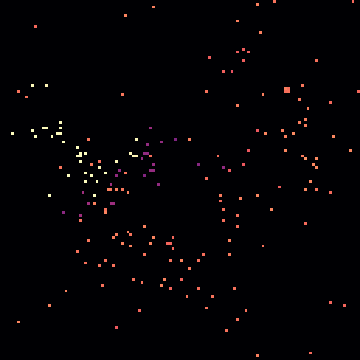
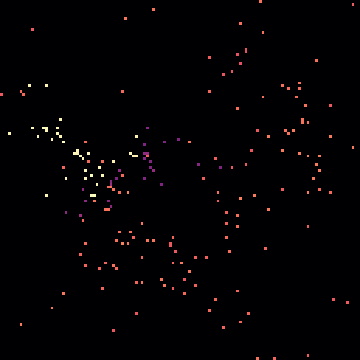

In [17]:
gr

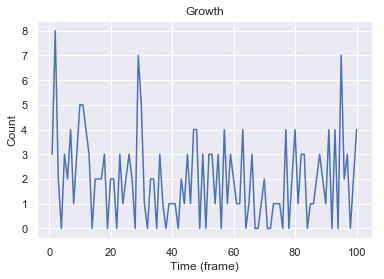

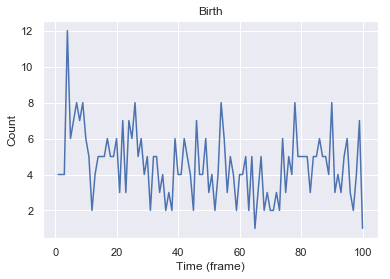

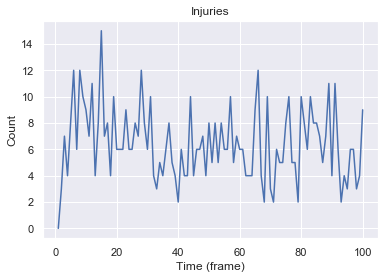

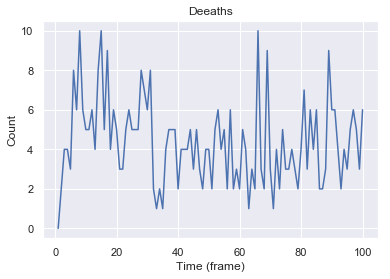

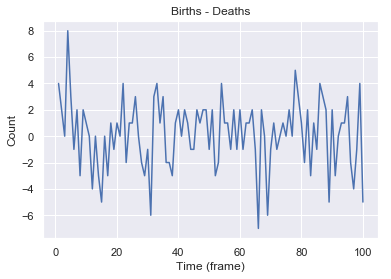

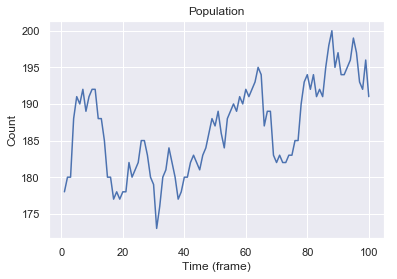

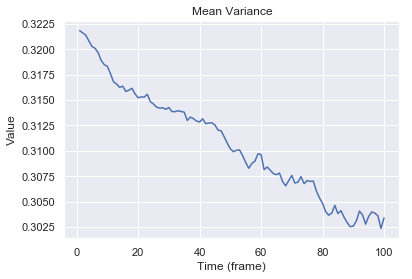

In [18]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [19]:
# Summary
t

array([[  1.        ,   3.        ,   4.        ,   0.        ,
          0.        , 178.        ,   0.32182846],
       [  2.        ,   8.        ,   4.        ,   3.        ,
          2.        , 180.        ,   0.32161976],
       [  3.        ,   2.        ,   4.        ,   7.        ,
          4.        , 180.        ,   0.32138745],
       [  4.        ,   0.        ,  12.        ,   4.        ,
          4.        , 188.        ,   0.32082283],
       [  5.        ,   3.        ,   6.        ,   8.        ,
          3.        , 191.        ,   0.32028324],
       [  6.        ,   2.        ,   7.        ,  12.        ,
          8.        , 190.        ,   0.32009933],
       [  7.        ,   4.        ,   8.        ,   6.        ,
          6.        , 192.        ,   0.31967754],
       [  8.        ,   1.        ,   7.        ,  12.        ,
         10.        , 189.        ,   0.31890088],
       [  9.        ,   3.        ,   8.        ,  10.        ,
          6.    

In [20]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 510\nNumber of edges: 455\nAverage degree:   1.7843'

In [21]:
#import dill
#dill.dump_session('notebook_env.db')

In [22]:
#import dill
#dill.load_session('notebook_env.db')